# LZIFU: properties of the whole sample

In [50]:
## Imports
import sys
import os 
import numpy as np
import pandas as pd
from astropy.visualization import hist

from spaxelsleuth.loaddata.lzifu import load_lzifu_galaxy
from spaxelsleuth.loaddata.sami import load_sami_galaxies
from spaxelsleuth.plotting.plot2dmap import plot2dmap
from spaxelsleuth.plotting.sdssimg import plot_sdss_image
from spaxelsleuth.plotting.plottools import plot_empty_BPT_diagram, plot_BPT_lines
from spaxelsleuth.plotting.plottools import vmin_fn, vmax_fn, label_fn, cmap_fn
from spaxelsleuth.plotting.plottools import component_colours, ncomponents_colours
from spaxelsleuth.plotting.plotgalaxies import plot2dscatter, plot2dhistcontours

import matplotlib
from matplotlib import rc, rcParams
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

rc("text", usetex=False)
rc("font",**{"family": "serif", "size": 14})
rcParams["savefig.bbox"] = "tight"
rcParams["savefig.format"] = "pdf"
plt.ion()
plt.close("all")

In [9]:
# Options
fig_path = "/priv/meggs3/u5708159/SAMI/figs/full_sample/"
savefigs = False


In [3]:
# Load the SAMI sample
df_sami = load_sami_galaxies(ncomponents="recom",
                             bin_type="default",
                             eline_SNR_min=5, 
                             vgrad_cut=False,
                             correct_extinction=False,
                             sigma_gas_SNR_cut=True)

/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

### Load each galaxy; merge into a single DataFrame

In [4]:
# List all galaxies we have LZIFU data for
lzifu_data_path = "/priv/meggs3/u5708159/LZIFU/products/"
gals_lzifu = [int(f.split("_merge_lzcomp.fits")[0]) for f in os.listdir(lzifu_data_path) if f.endswith("merge_lzcomp.fits") and not f.startswith("._")]    

# Shortlist: SF galaxies only (but how is this defined?)
gals_shortlist = [64553, 106717, 30346, 41144, 609396, 9388000219, 144491, 106042, 240108, 184368, 8703, 544958, 460374, 537361, 144402, 204799, 463668, 85416, 463288, 511867, 24013, 561020, 144239, 298666, 288364, 176955, 84107, 585386, 99349, 287824, 610398, 551202, 240449, 55150, 69620, 534753, 14812, 545925, 105597, 3630097, 8353, 77754, 220439, 383318, 618116, 144051, 278548, 396833, 238358, 485834, 518782, 622744, 143814, 106376, 623432, 221375]
gals_good = [g for g in gals_shortlist if g in gals_lzifu]

In [58]:
df = None
for gal in gals_good:
    # Load LZIFU data
    df_gal = load_lzifu_galaxy(gal=gal, bin_type="default", ncomponents="recom",
                       eline_SNR_min=5,
                       sigma_gas_SNR_cut=True,
                       vgrad_cut=False,
                       stekin_cut=False)
    if df is not None:
        df = pd.concat([df, df_gal], ignore_index=True)
    else:
        df = df_gal

df.loc[df["Number of components"] == 0, "Number of components"] = np.nan
        

/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


### [SII] ratio

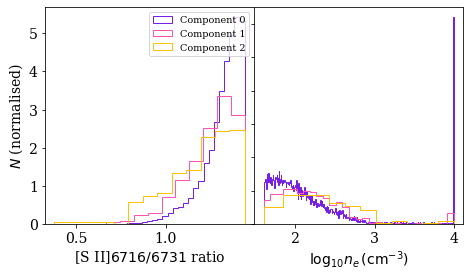

In [59]:
#############################################################################################
# Line ratios
#############################################################################################
# Compute electron denstiy
from spaxelsleuth.loaddata.linefns import Proxauf2014

for ii in range(3):
    df[f"n_e (cm^-3) (component {ii})"] = Proxauf2014(df[f"S2 ratio (component {ii})"])
    df[f"log n_e (cm^-3) (component {ii})"] = np.log10(df[f"n_e (cm^-3) (component {ii})"])

# Set up figure
col_list = ["S2 ratio", "log n_e (cm^-3)"]
fig, axs = plt.subplots(nrows=1, ncols=len(col_list), sharey=False, figsize=(15 / 4 * len(col_list), 4))
fig.subplots_adjust(wspace=0)
if type(axs) != np.ndarray:
    axs = [axs]

for col, ax in zip(col_list, axs if len(axs) == 1 else axs.flat):
    # Plot histograms for the full sample.
    for ii in range(3):
        hist(df[f"{col} (component {ii})"], histtype="step", density=True,
             ax=ax,
             color=component_colours[ii], bins="knuth", 
             range=(vmin_fn(col), vmax_fn(col)),
             label=f"Component {ii}")
    ax.set_xlabel(label_fn(col))

# Decorations
axs[0].set_ylabel(r"$N$ (normalised)")
axs[0].legend(loc="upper right", fontsize="x-small")
for ax in axs[1:]:
    ax.set_yticklabels([])
    
# Save
if savefigs:
    fig.savefig(os.path.join(fig_path, f"hist_grid_LZIFU_S2_ratio_full_sample.pdf"),
                format="pdf", bbox_inches="tight")


### Histograms line ratios (and other properties) of the components 0, 1 and 2 for the whole sample of high-S/N star-forming galaxies

No handles with labels found to put in legend.


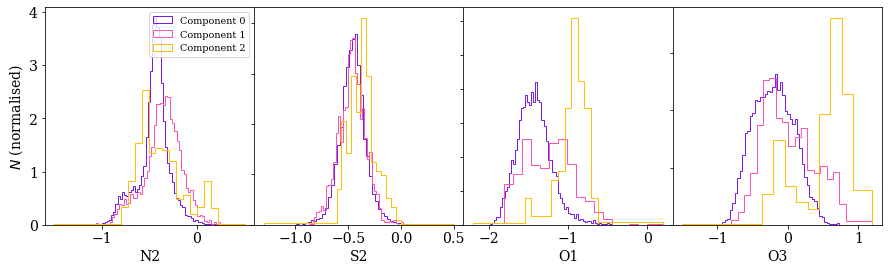

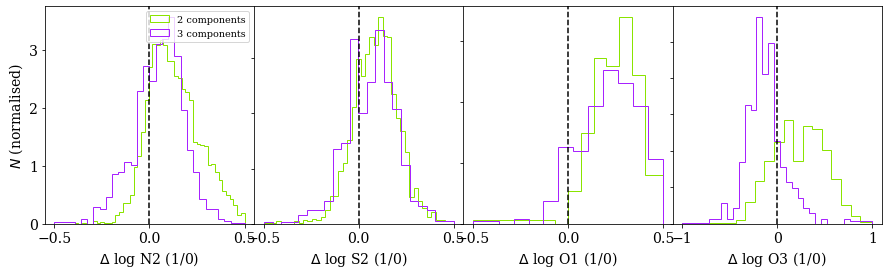

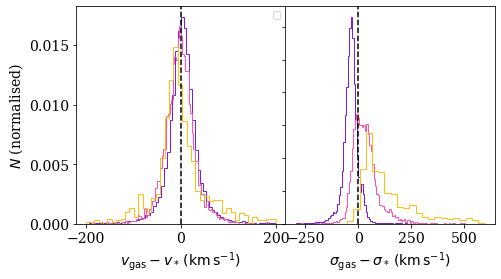

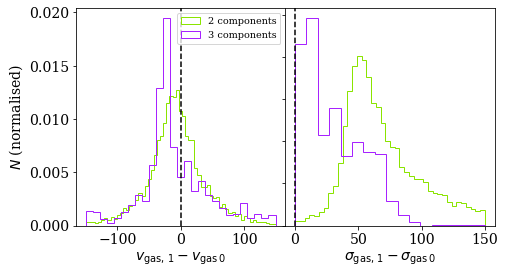

In [60]:
#############################################################################################
# Line ratios
#############################################################################################
# Set up figure
col_list = ["log N2", "log S2", "log O1", "log O3"]
fig, axs = plt.subplots(nrows=1, ncols=4, sharey=False, figsize=(15, 4))
fig.subplots_adjust(wspace=0)

for col, ax in zip(col_list, axs.flat):
    # Plot histograms for the full sample.
    for ii in range(3):
        hist(df[f"{col} (component {ii})"], histtype="step", density=True,
             color=component_colours[ii],
             bins="knuth", ax=ax,  
             range=(-200 if col == "v_gas - v_*" else vmin_fn(col), 
                    +200 if col == "v_gas - v_*" else vmax_fn(col)),
              label=f"Component {ii}")
    ax.set_xlabel(label_fn(col))

# Decorations
axs[0].set_ylabel(r"$N$ (normalised)")
axs[0].legend(loc="upper right", fontsize="x-small")
for ax in axs[1:]:
    ax.set_yticklabels([])
    
# Save
if savefigs:
    fig.savefig(os.path.join(fig_path, f"hist_grid_LZIFU_line_ratios_full_sample.pdf"),
                format="pdf", bbox_inches="tight")

#############################################################################################
# Difference in line ratios
#############################################################################################
# Set up figure
col_list = ["delta log N2 (1/0)", "delta log S2 (1/0)", "delta log O1 (1/0)", "delta log O3 (1/0)"]
fig, axs = plt.subplots(nrows=1, ncols=4, sharey=False, figsize=(15, 4))
fig.subplots_adjust(wspace=0)

for col, ax in zip(col_list, axs.flat):
    # Plot histograms for the full sample.
    for nn in [2, 3]:
        hist(df.loc[df["Number of components"] == nn, f"{col}"], histtype="step", density=True,
             color=ncomponents_colours[nn], 
             bins="knuth", ax=ax, 
             range=(-200 if col == "v_gas - v_*" else vmin_fn(col), 
                    +200 if col == "v_gas - v_*" else vmax_fn(col)),
             label=f"{nn} components")
    ax.set_xlabel(label_fn(col))
    ax.axvline(0, color="k", linestyle="--")

# Decorations
axs[0].set_ylabel(r"$N$ (normalised)")
axs[0].legend(loc="upper right", fontsize="x-small")
for ax in axs[1:]:
    ax.set_yticklabels([])
    
# Save
if savefigs:
    fig.savefig(os.path.join(fig_path, f"hist_grid_LZIFU_delta_line_ratios_full_sample.pdf"),
                format="pdf", bbox_inches="tight")

#############################################################################################
# Kinematics
#############################################################################################
# Set up figure
col_list = ["v_gas - v_*", "sigma_gas - sigma_*"]
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(7.5, 4))
fig.subplots_adjust(wspace=0)

for col, ax in zip(col_list, axs.flat):
    # Plot histograms for the full sample.
    for ii in range(3):
        hist(df[f"{col} (component {ii})"], histtype="step", density=True,
             color=component_colours[ii], 
             bins="knuth", ax=ax, 
             range=(-200 if col == "v_gas - v_*" else vmin_fn(col), 
                    +200 if col == "v_gas - v_*" else vmax_fn(col)))
    ax.set_xlabel(label_fn(col))
    ax.axvline(0, color="k", linestyle="--")

# Decorations
axs[0].set_ylabel(r"$N$ (normalised)")
axs[0].legend(loc="upper right", fontsize="x-small")
for ax in axs[1:]:
    ax.set_yticklabels([])

# Save
if savefigs:
    fig.savefig(os.path.join(fig_path, f"hist_grid_LZIFU_kinematics_full_sample.pdf"),
                format="pdf", bbox_inches="tight")


#############################################################################################
# Difference in kinematics
#############################################################################################
# Set up figure
col_list = ["delta v_gas (1/0)", "delta sigma_gas (1/0)"]
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(7.5, 4))
fig.subplots_adjust(wspace=0)

for col, ax in zip(col_list, axs.flat):
    # Plot histograms for the full sample.
    for nn in [2, 3]:
        hist(df.loc[df["Number of components"] == nn, f"{col}"], histtype="step", density=True,
             color=ncomponents_colours[nn], 
             bins="knuth", ax=ax, 
             range=(-200 if col == "v_gas - v_*" else vmin_fn(col), 
                    +200 if col == "v_gas - v_*" else vmax_fn(col)),
             label=f"{nn} components")
    ax.set_xlabel(label_fn(col))
    ax.axvline(0, color="k", linestyle="--")

# Decorations
axs[0].set_ylabel(r"$N$ (normalised)")
axs[0].legend(loc="upper right", fontsize="x-small")
for ax in axs[1:]:
    ax.set_yticklabels([])
    
# Save
if savefigs:
    fig.savefig(os.path.join(fig_path, f"hist_grid_LZIFU_delta_kinematics_full_sample.pdf"),
                format="pdf", bbox_inches="tight")


### Histograms of line ratios (and other properties) of the components 0, 1 and 2 for each galaxy individually

In the figures below, we show histograms of N2, S2, O1, O3 for each kinematic component separately, as well as $\Delta v_{\rm gas 1,0}$ and $\Delta \sigma_{\rm gas 1,0}$.


ValueError: data should have more than three entries

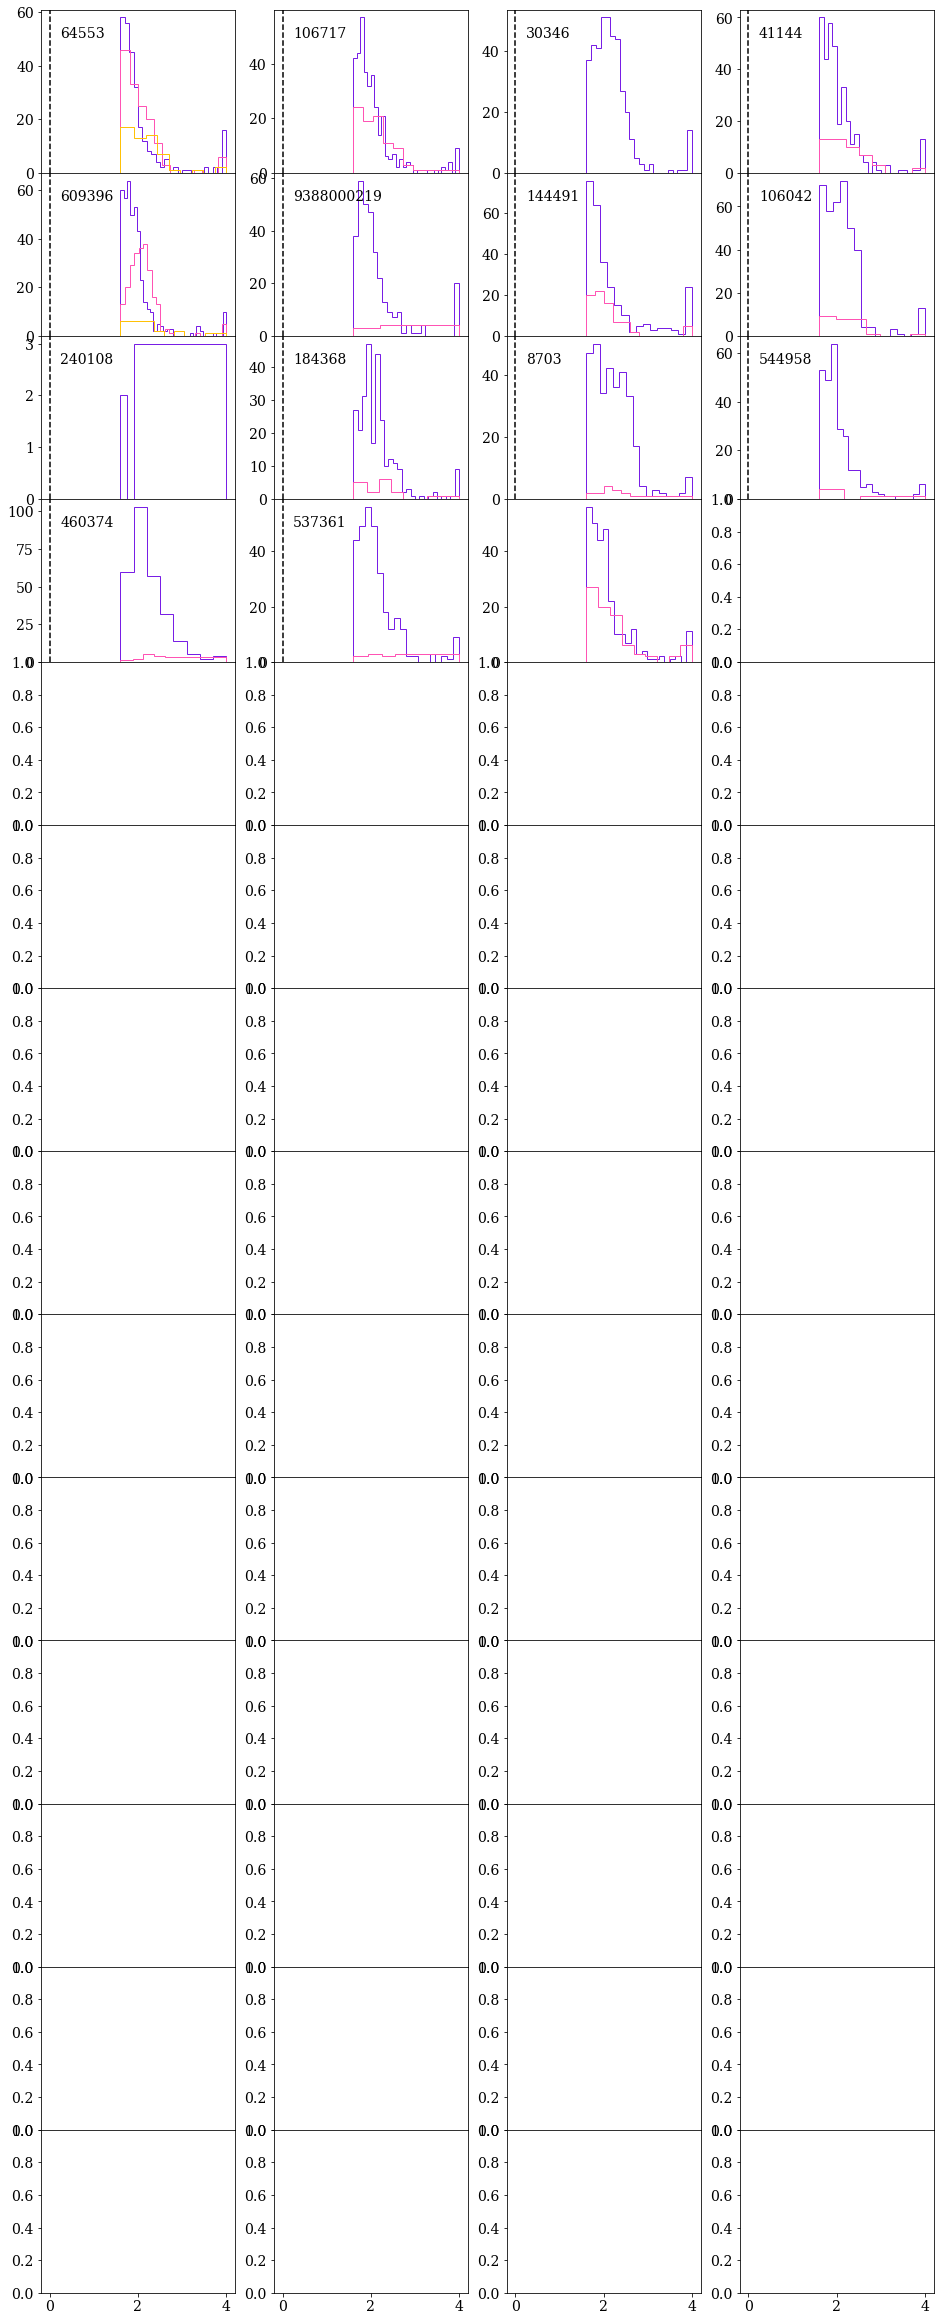

In [74]:
gals = df["catid"].unique()

# For debugging
# gals = gals[:8]

col_list = ["log N2", "log S2", "log O1", "log O3", "v_gas - v_*", "sigma_gas - sigma_*", "log n_e (cm^-3)"]
for col in col_list:
    # Set up figure
    ncols = 4
    nrows = int(np.ceil(len(gals) / float(ncols)))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=False, figsize=(4 * ncols, 3 * nrows))
    fig.subplots_adjust(hspace=0)

    # Plot histograms for each galaxy
    for gal, ax in zip(gals, axs.flat):
        df_gal = df[df["catid"] == gal]
        for ii in range(3):
            if df_gal[f"{col} (component {ii})"].count() > 10:
                hist(df_gal[f"{col} (component {ii})"], histtype="step", density=False,
                     color=component_colours[ii], 
                     bins="knuth", ax=ax,
                     range=(-200 if col == "v_gas - v_*" else vmin_fn(col), 
                            +200 if col == "v_gas - v_*" else vmax_fn(col)),
                    label=f"Component {ii}")
        ax.text(s=gal, y=0.9, x=0.1, verticalalignment="top", horizontalalignment="left", transform=ax.transAxes)
        if "-" in col:
            ax.axvline(0, color="k", linestyle="--")
    
    # Decorations
    axs[0][0].legend(loc="upper right", fontsize="x-small")
    for cc in range(ncols):
        axs[0][cc].xaxis.set_tick_params(labeltop='on')
        axs[-1][cc].set_xlabel(label_fn(col))
        axs[0][cc].set_title(label_fn(col), fontsize="medium")
    for rr in range(nrows):
        axs[rr][0].set_ylabel(r"$N$")
    for ax in axs.flat:
        ax.grid()
    for ax in axs.flat[len(gals):]:
        ax.set_visible(False)
    for ax in axs.flat[len(gals) - 4:len(gals)]:
        ax.set_xlabel(label_fn(col))
    
    # Save
    if savefigs:
        fig.savefig(os.path.join(fig_path, f"hist_grid_LZIFU_{col.replace(' ', '_').replace('*', 'star')}.pdf"),
                    format="pdf", bbox_inches="tight")


In [70]:
df_gal.count?

In [ ]:
df_gal[f"{col} (component {ii})"].count

### Histograms showing the *difference* between line ratios and kinematic parameters between components 0 and 1

/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/numpy/lib

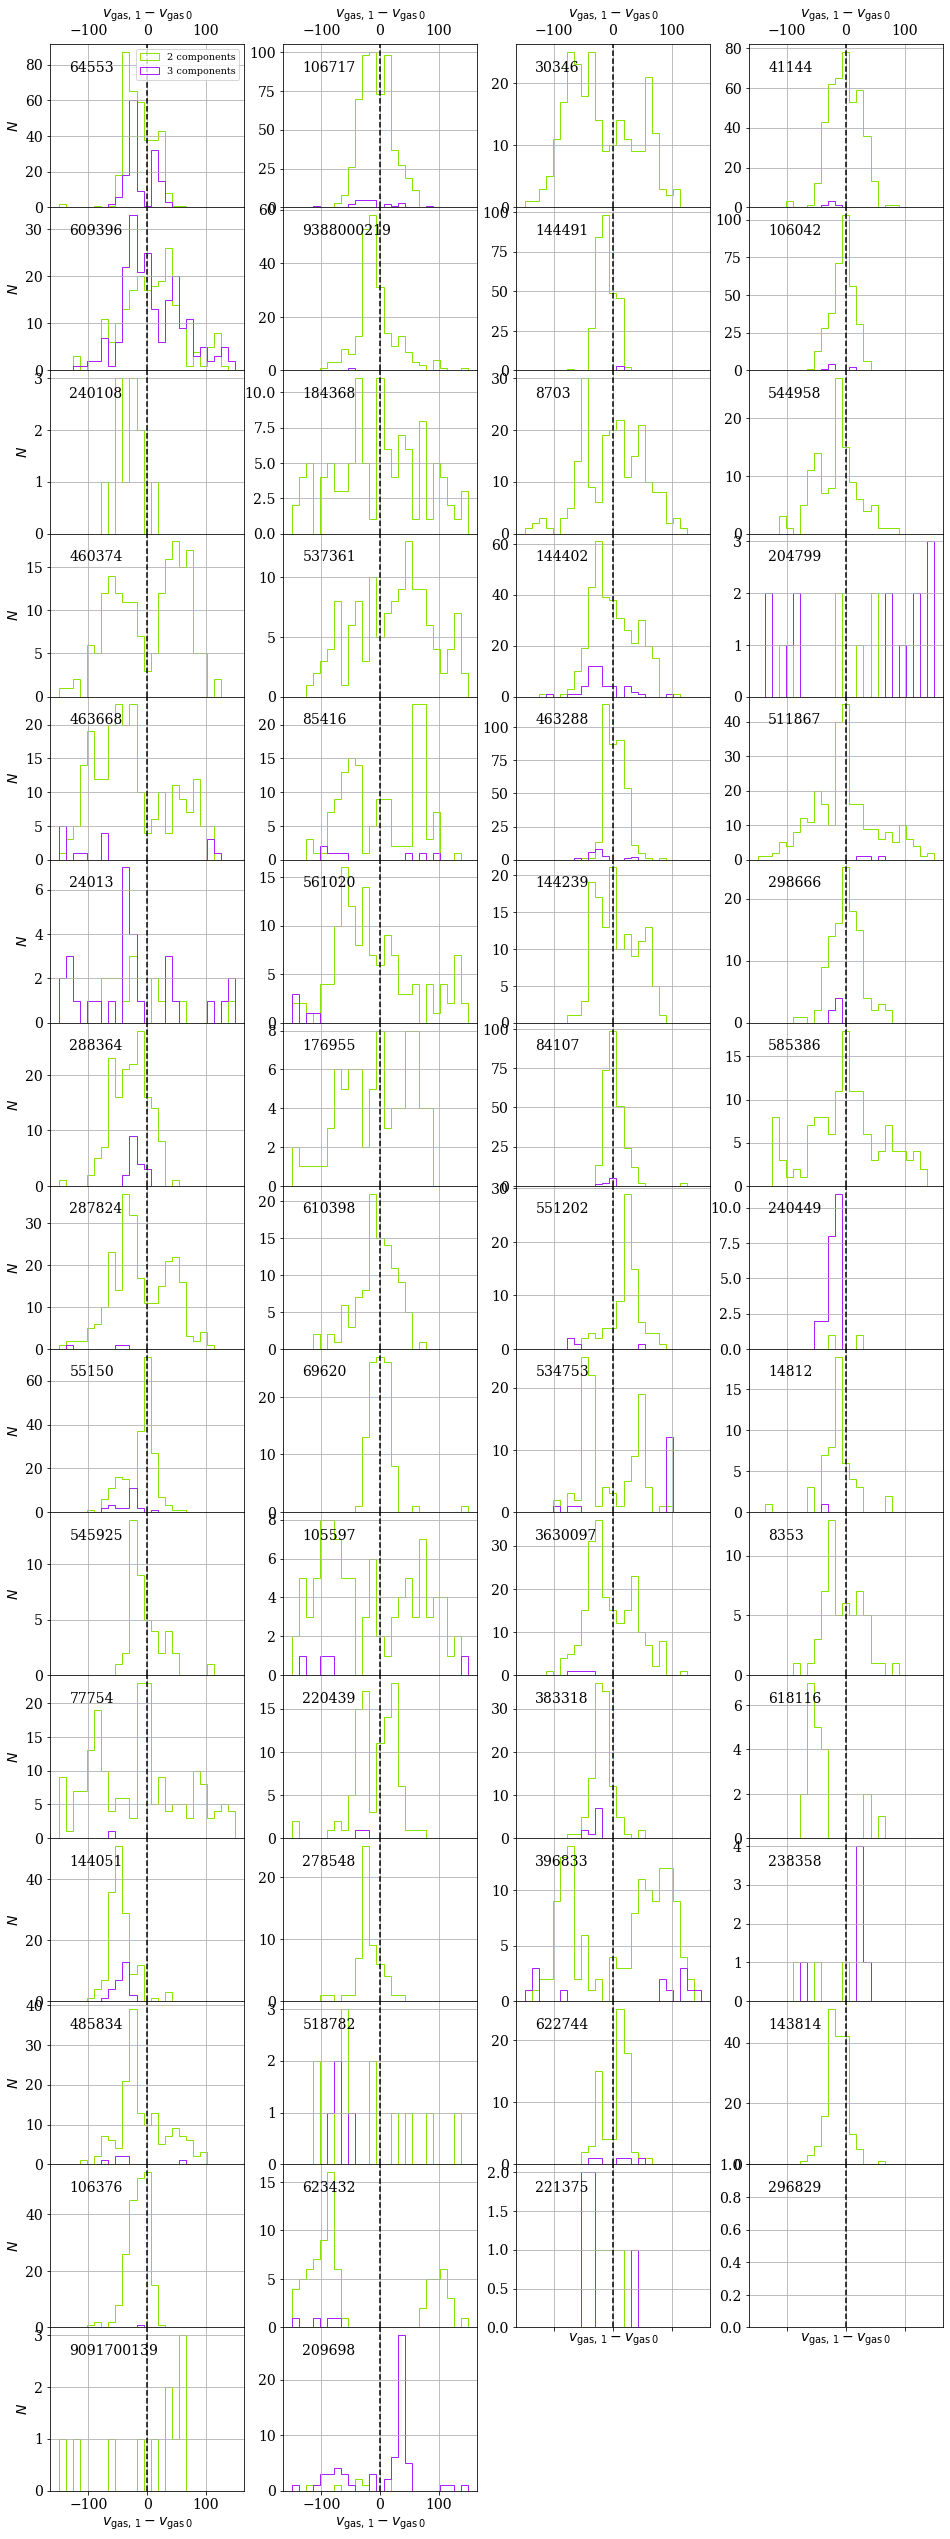

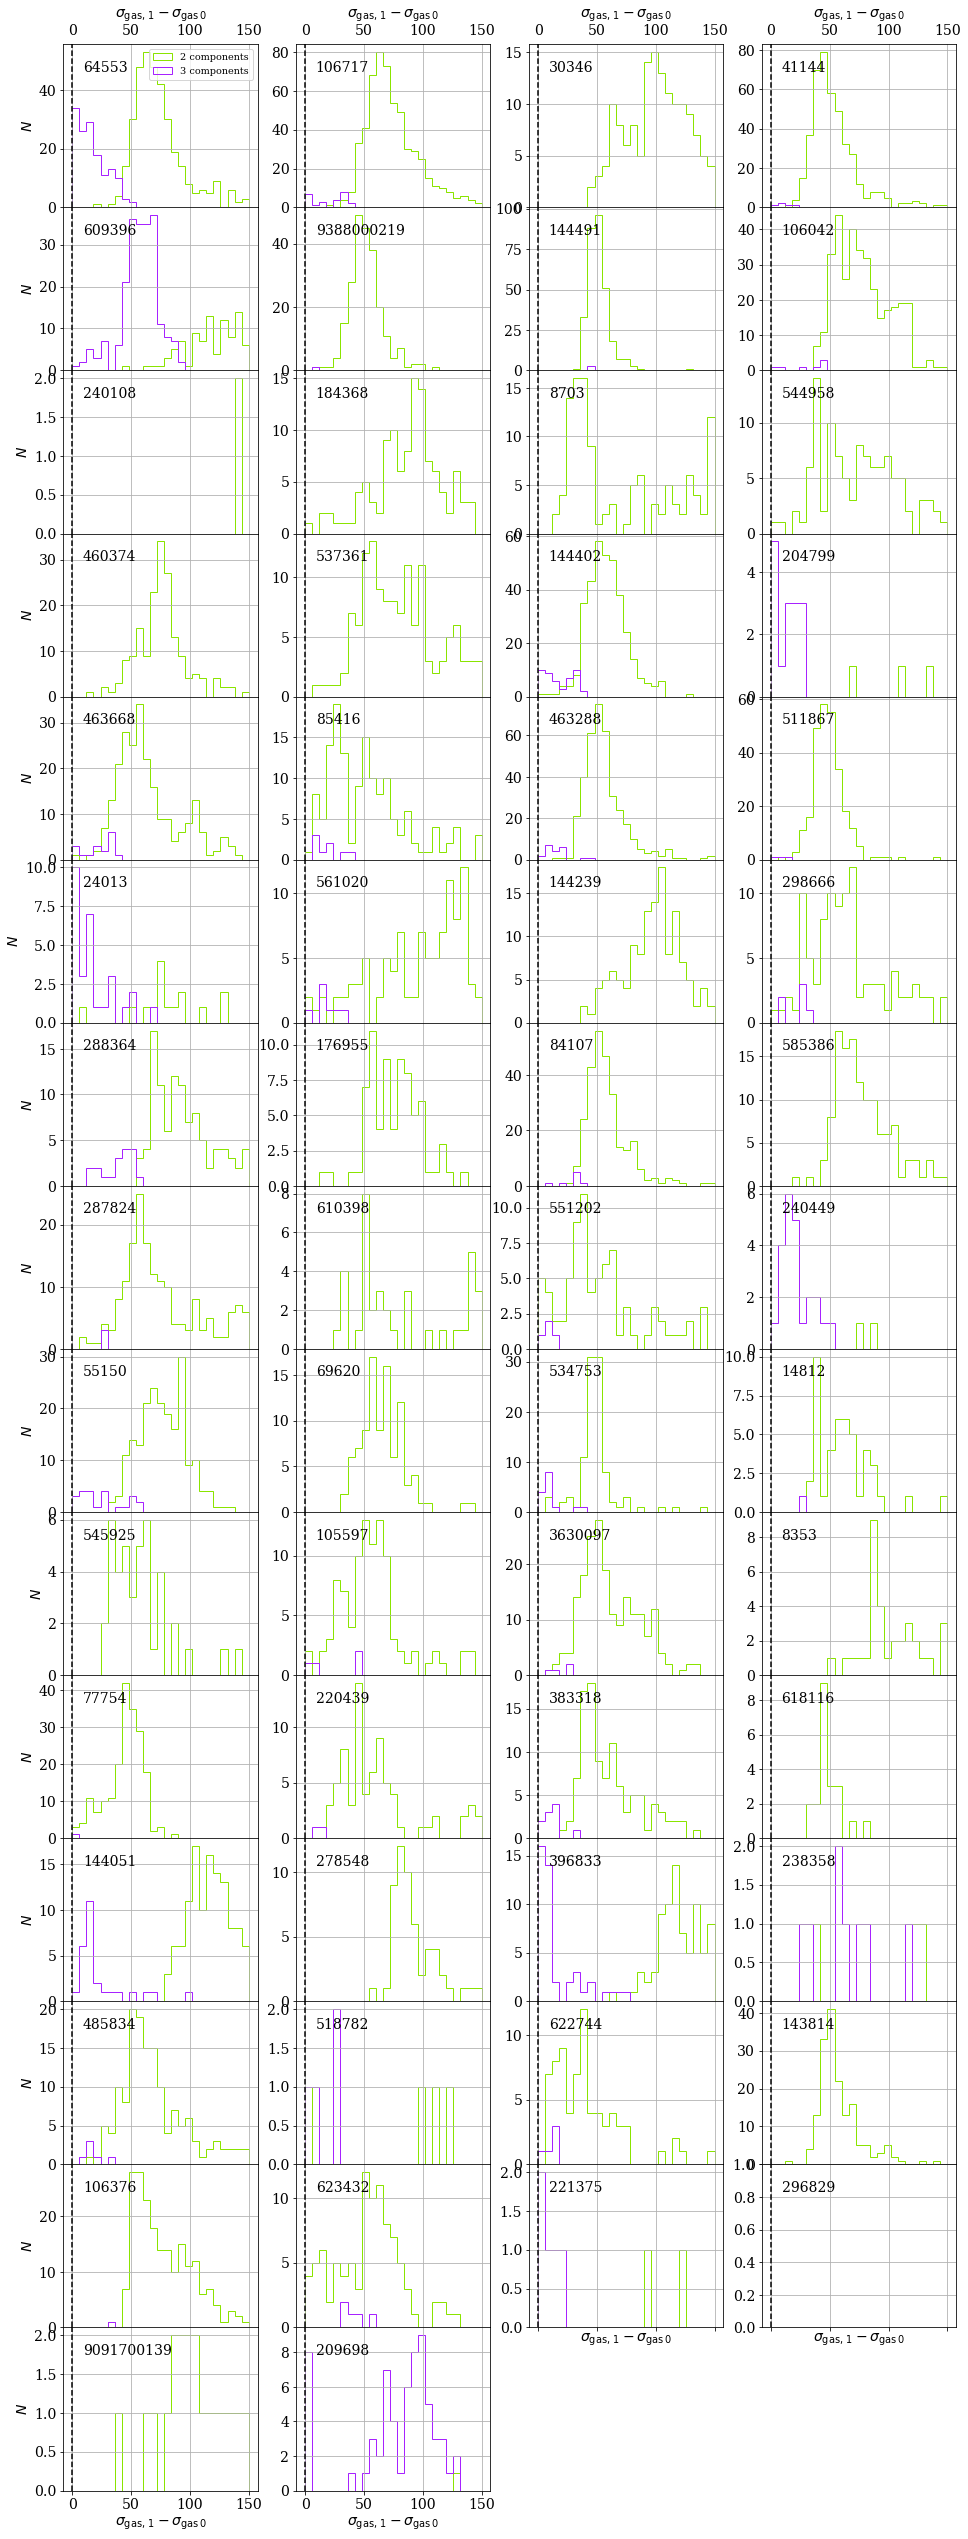

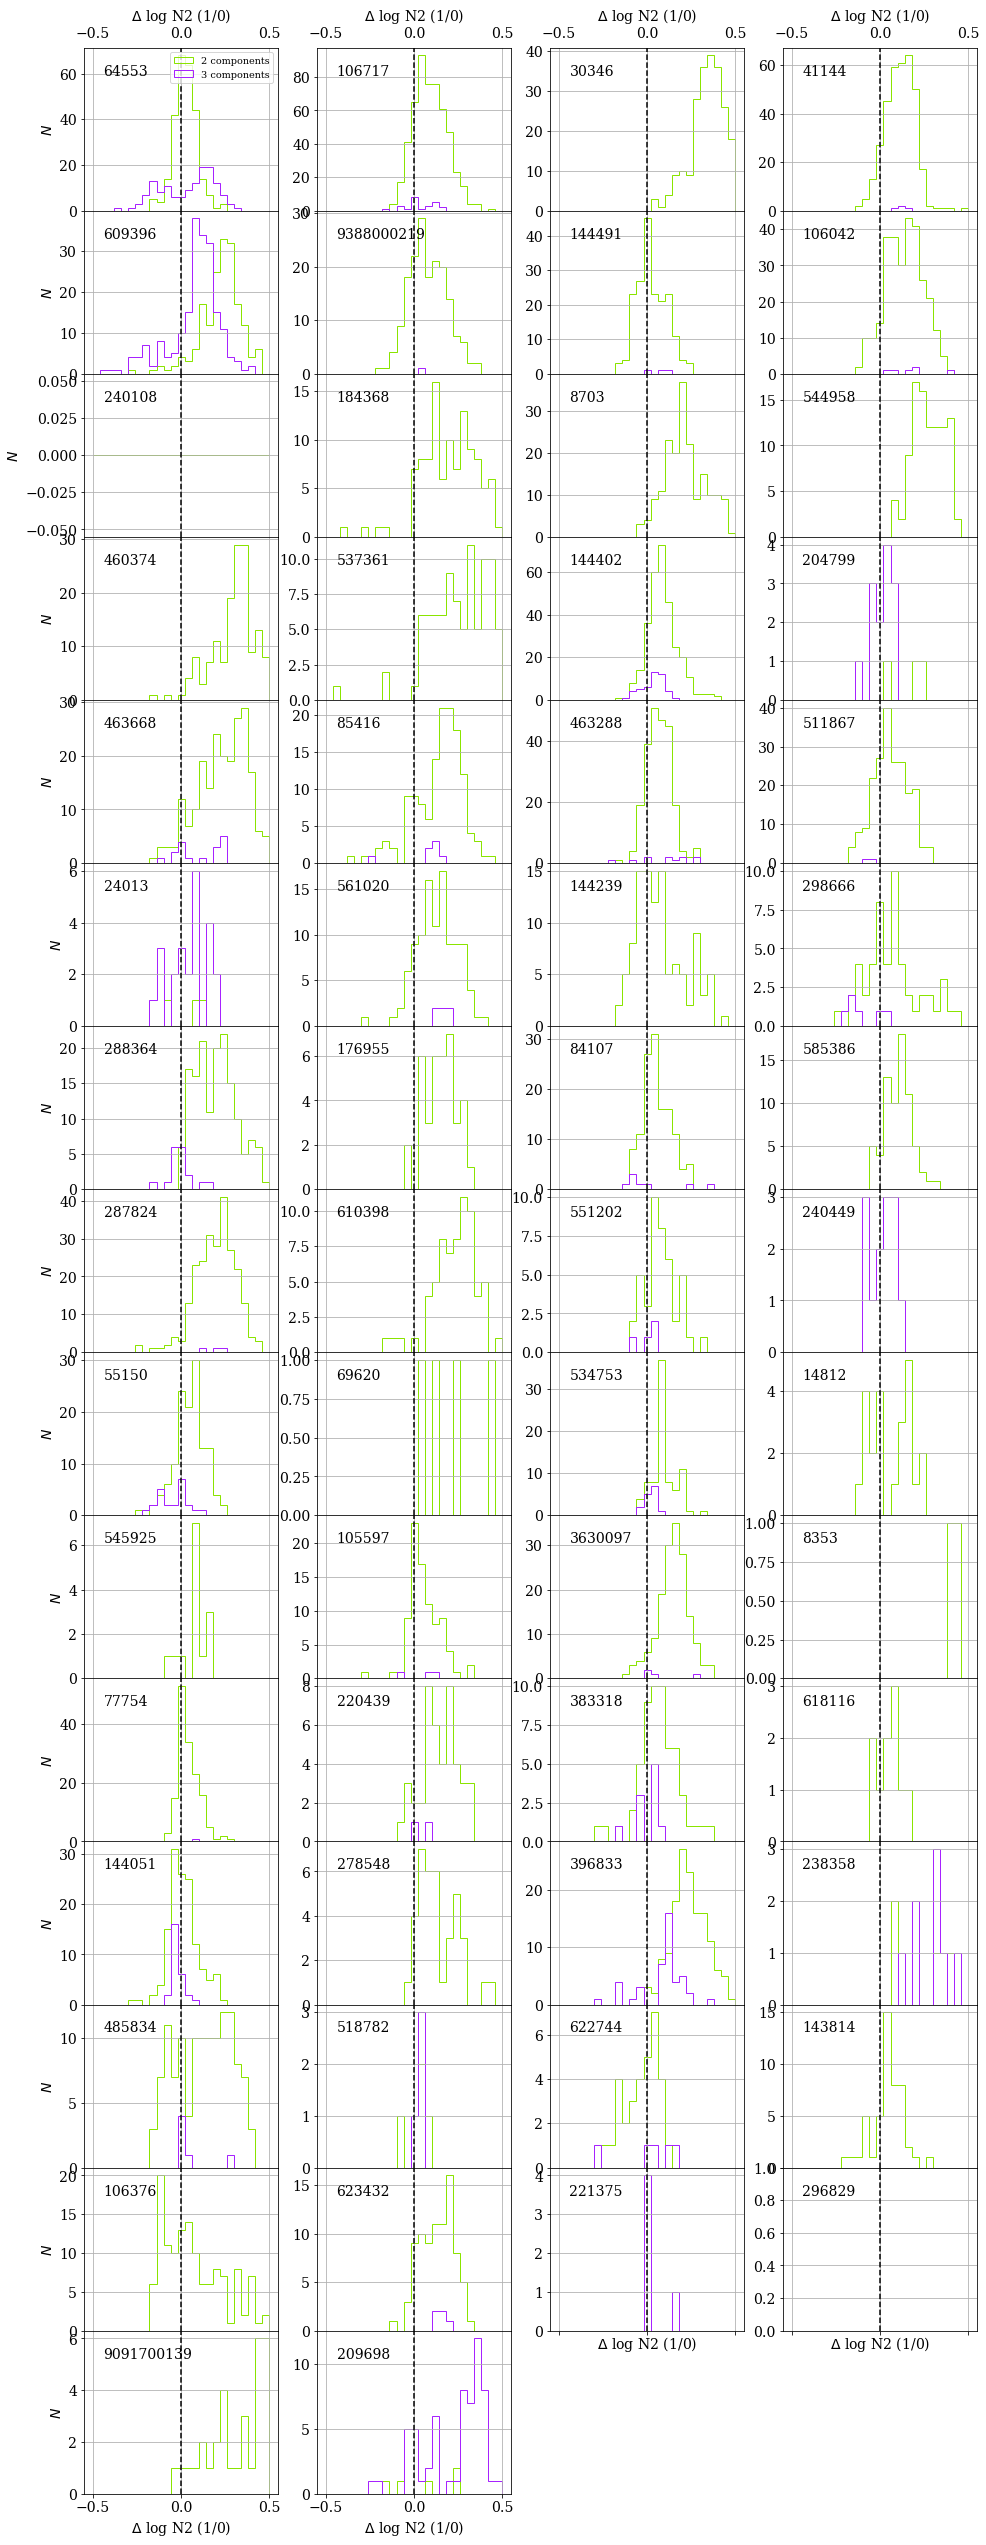

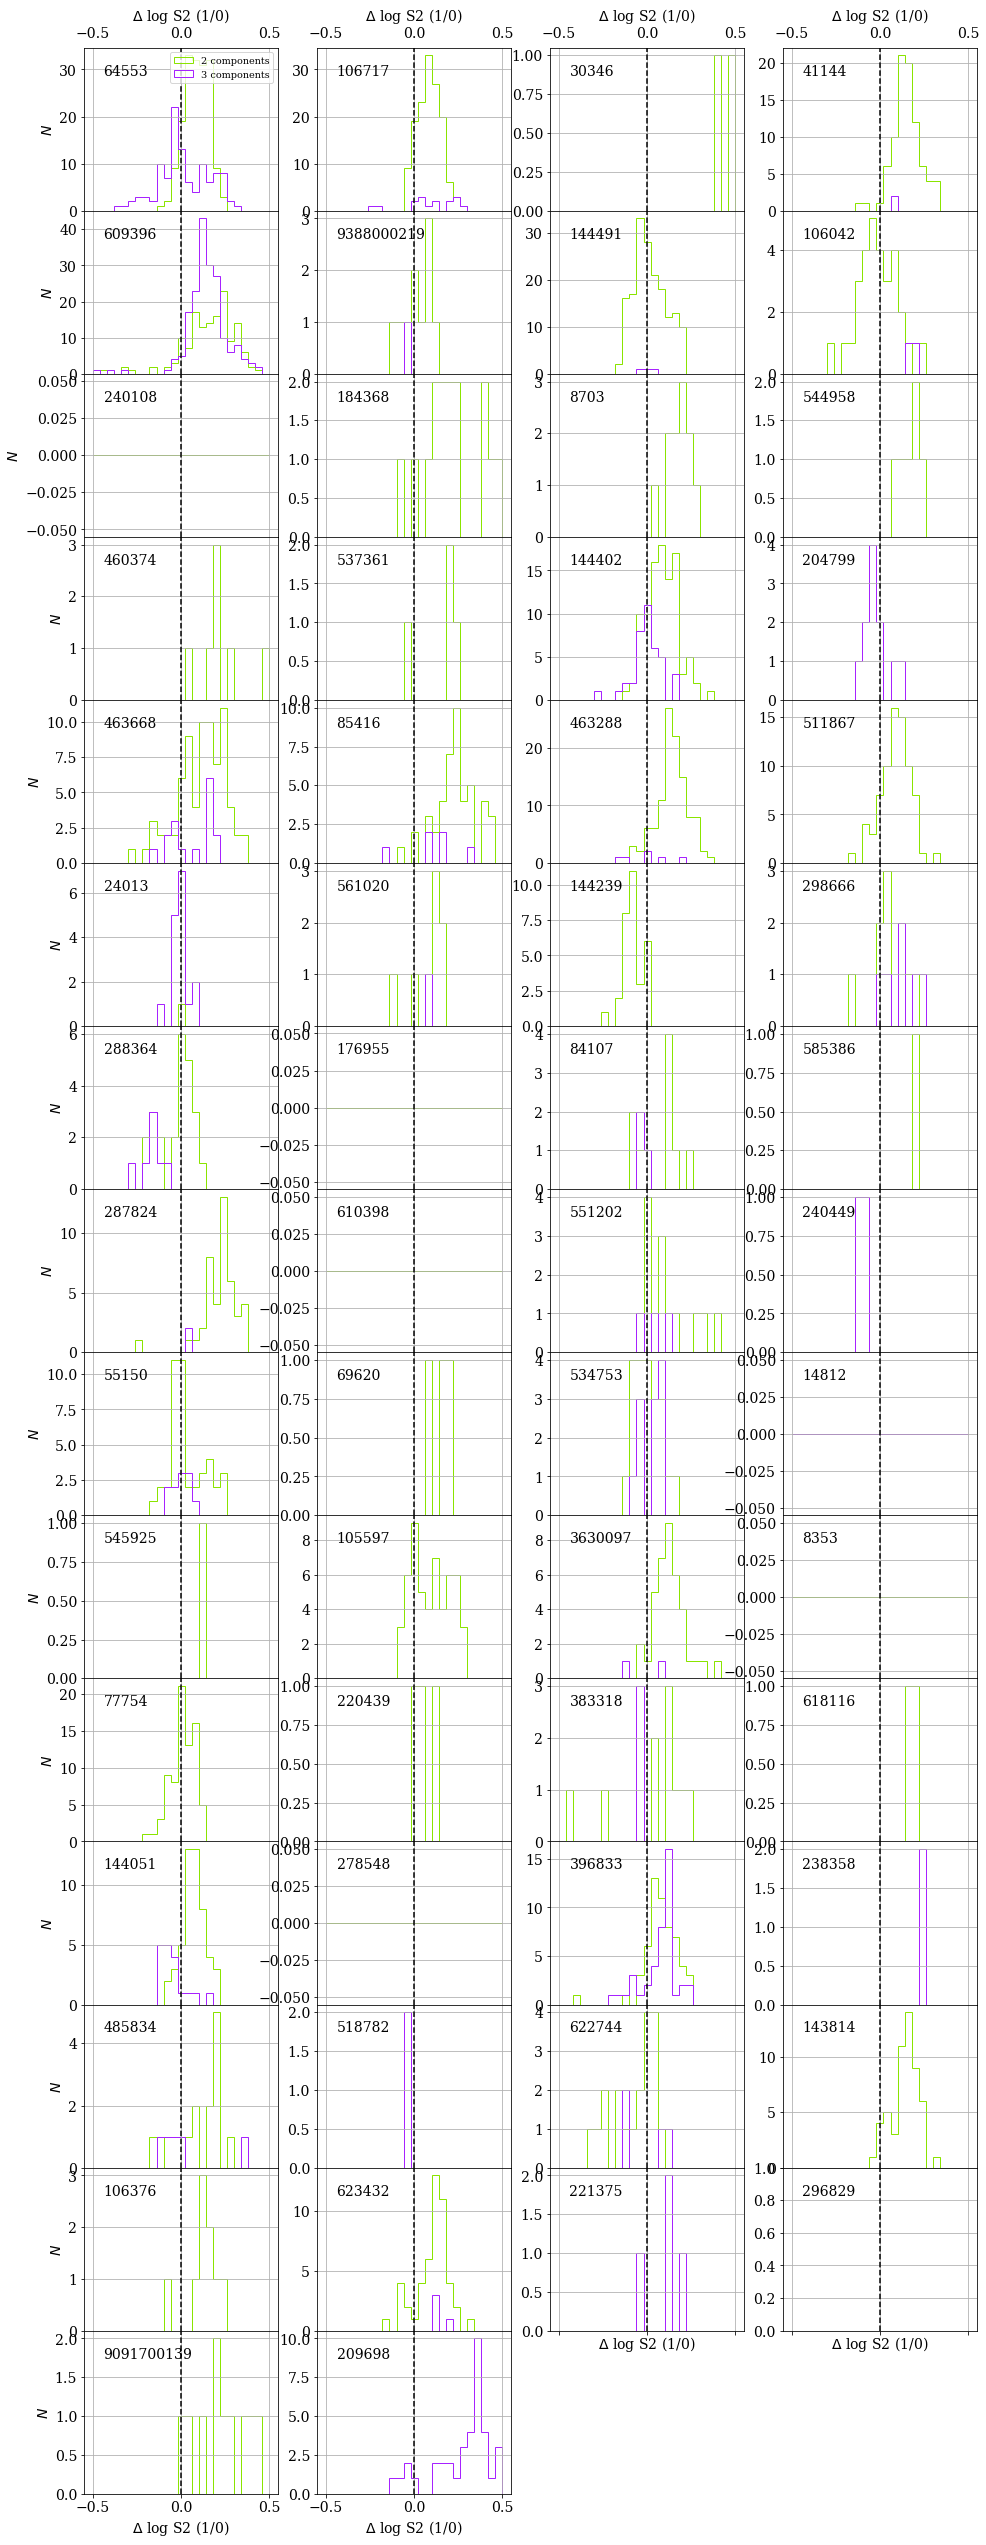

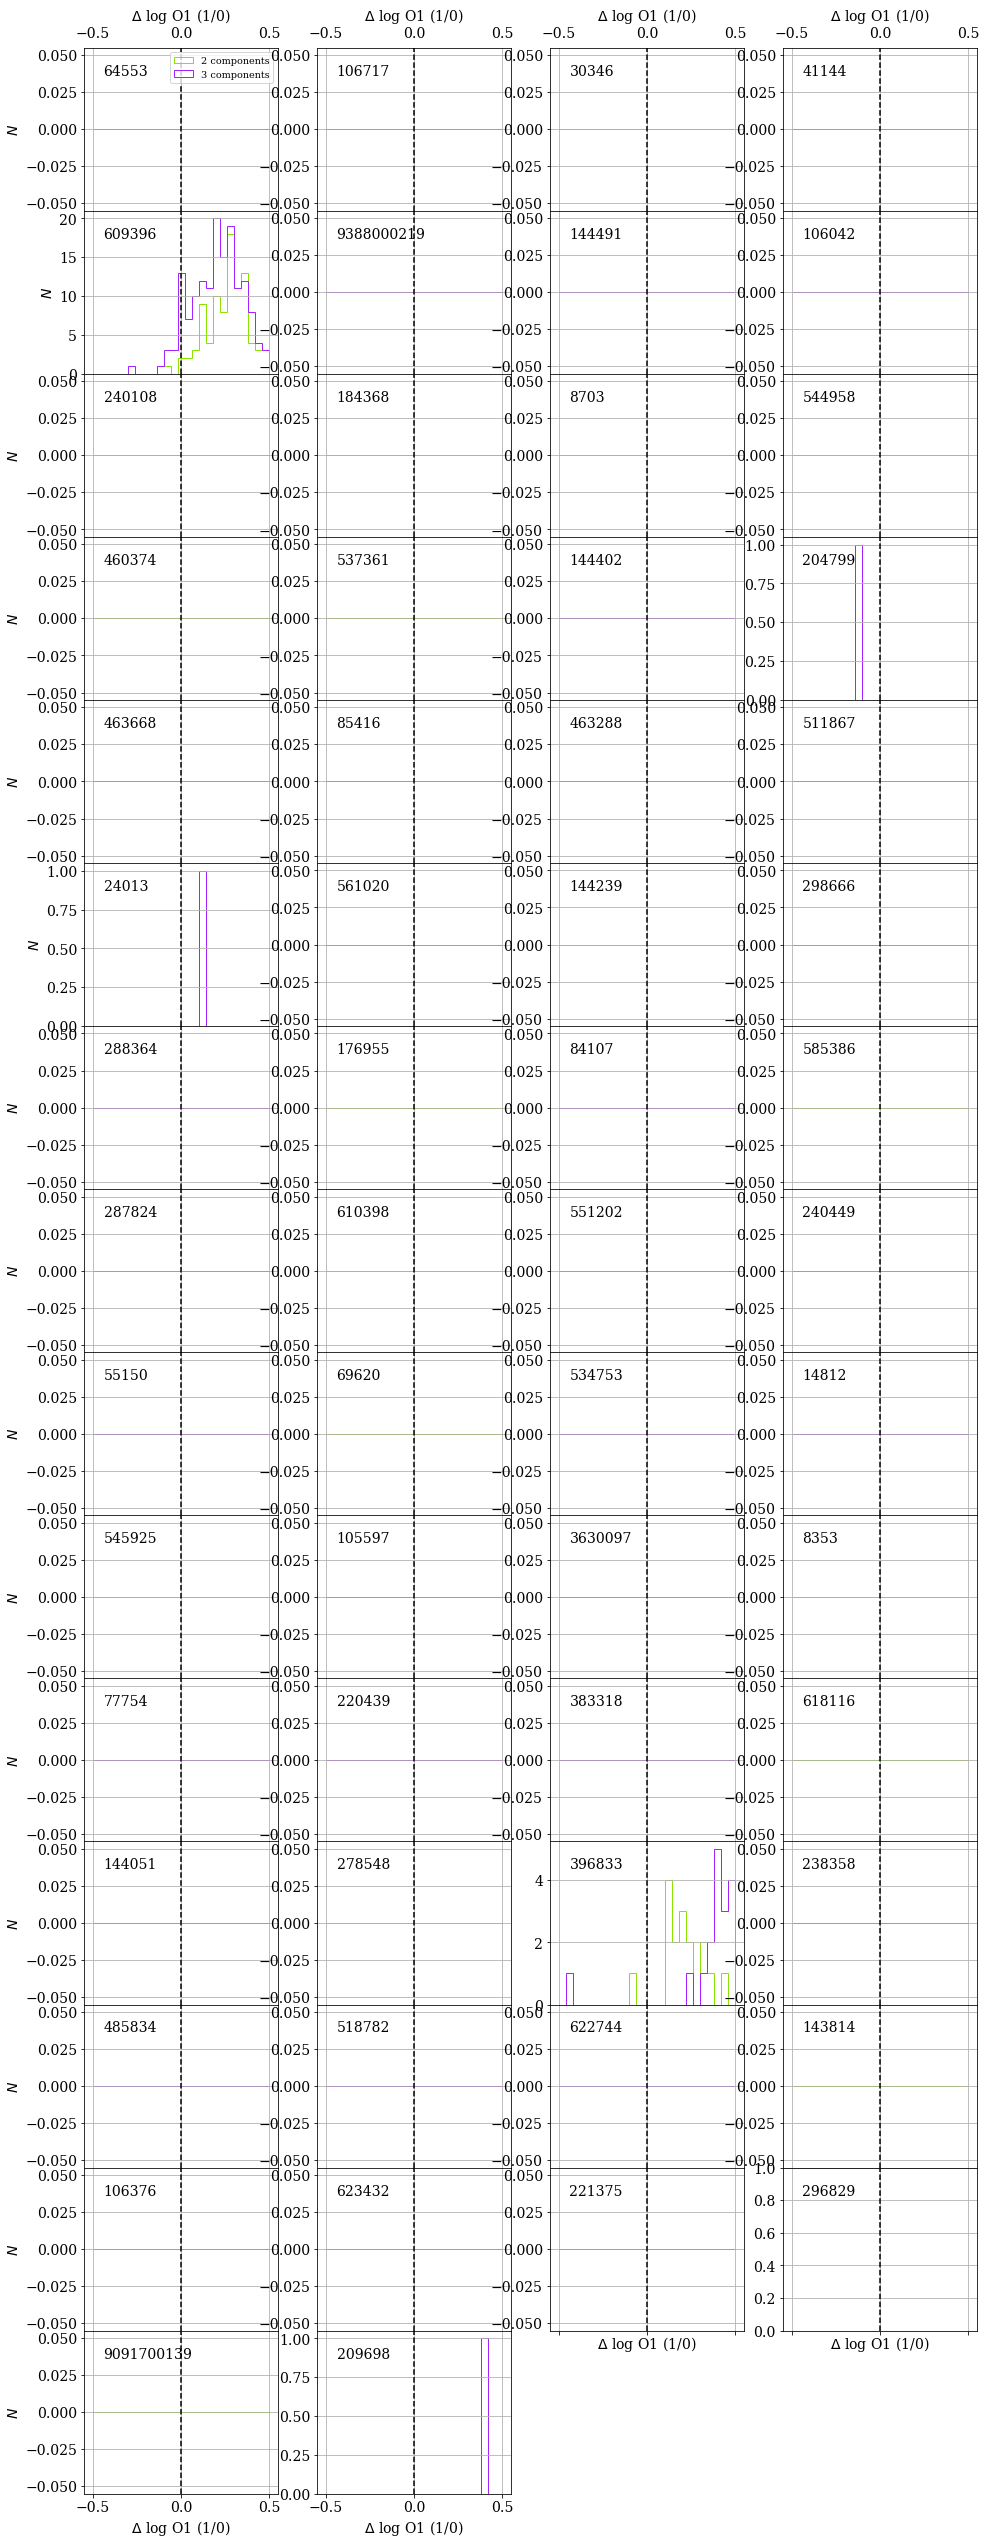

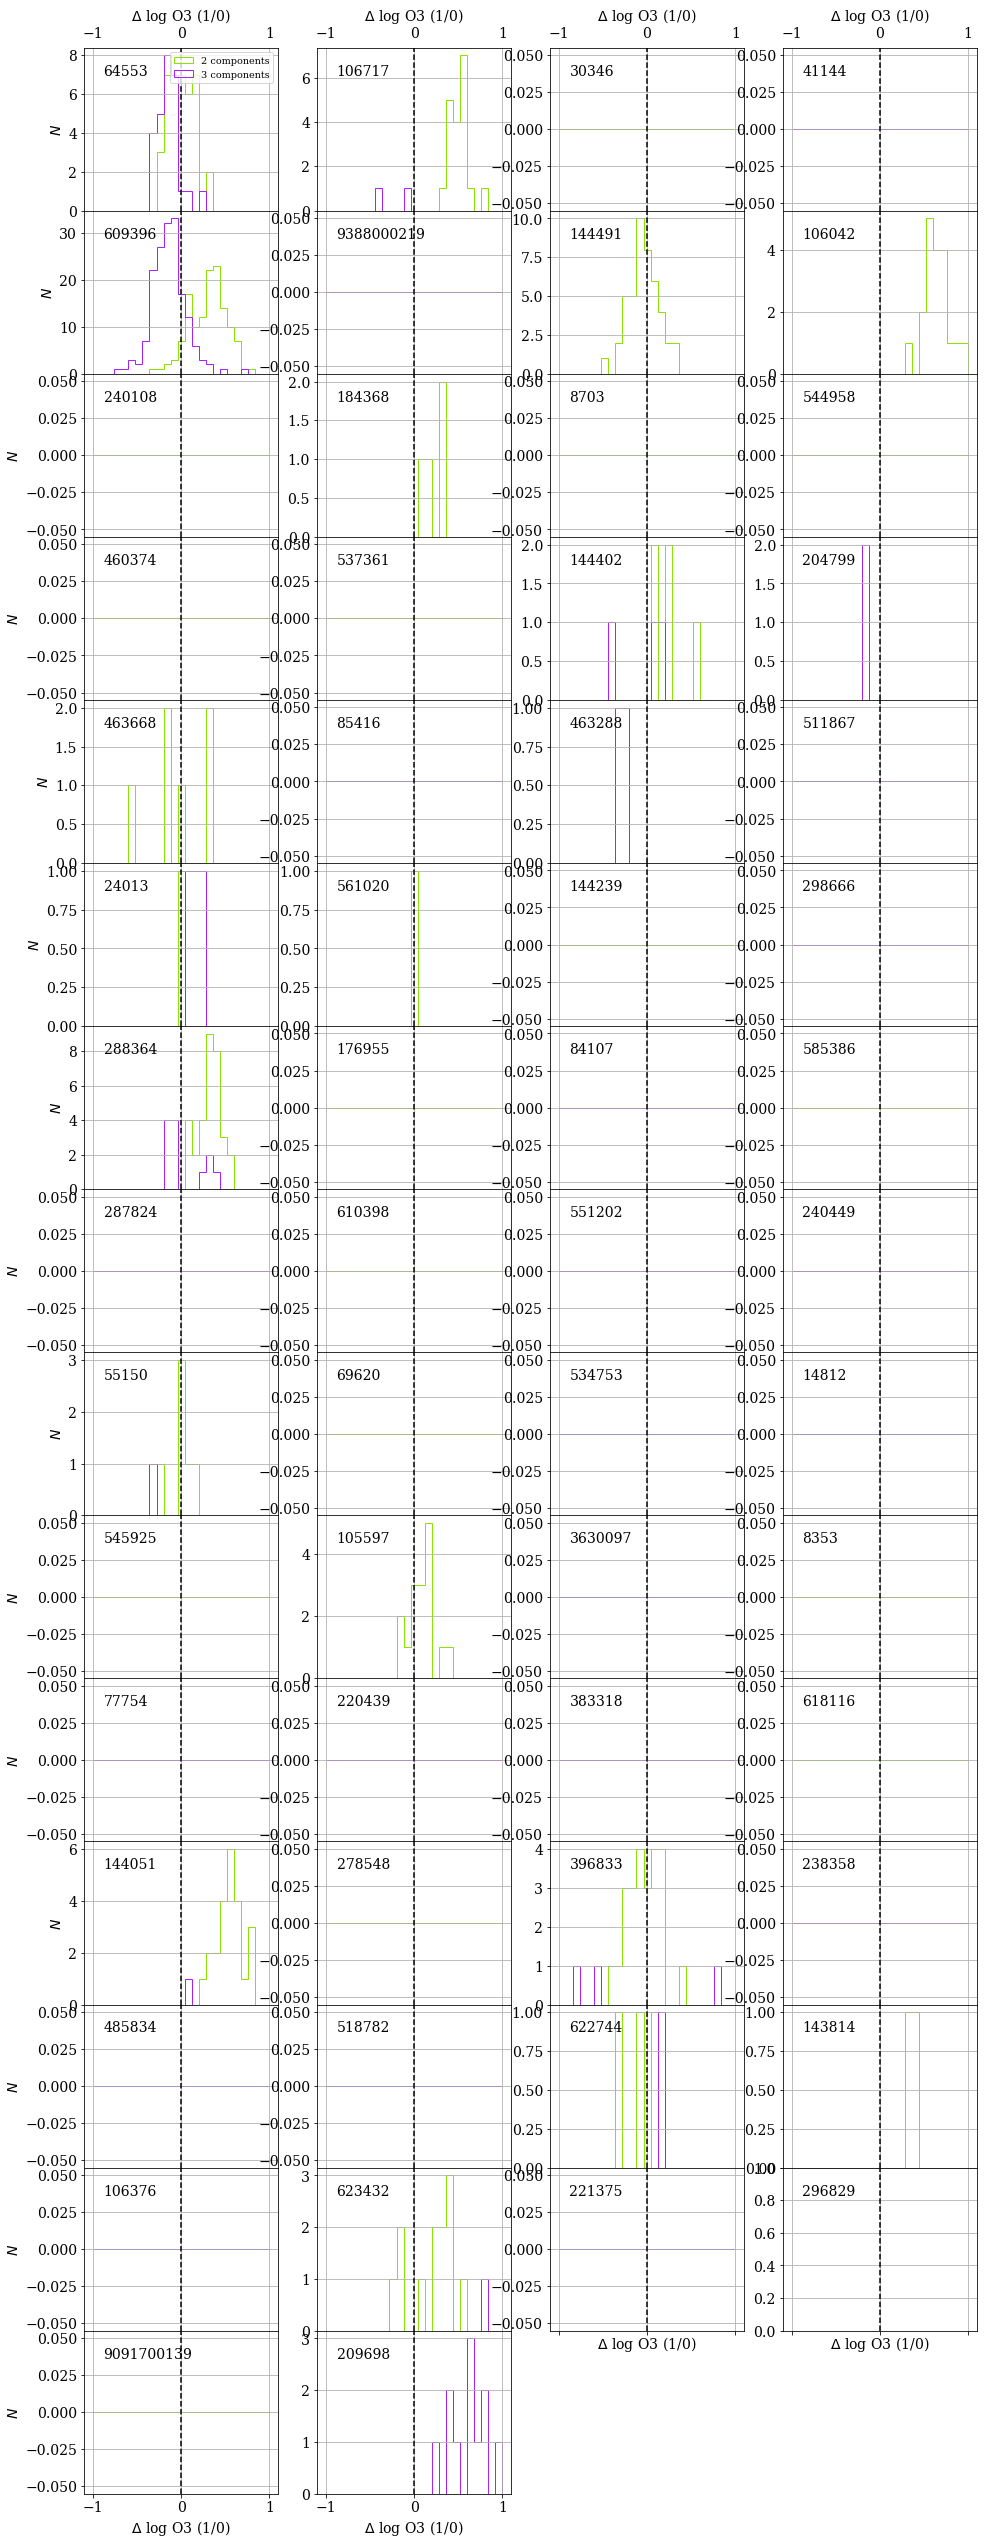

In [44]:
from IPython.core.debugger import Tracer
gals = df["catid"].unique()

# For debugging
# gals = gals[:8]

for col in ["delta v_gas (1/0)", "delta sigma_gas (1/0)", 
            "delta log N2 (1/0)", "delta log S2 (1/0)", "delta log O1 (1/0)", "delta log O3 (1/0)"]:
    # Set up figure
    ncols = 4
    nrows = int(np.ceil(len(gals) / float(ncols)))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=False, figsize=(4 * ncols, 3 * nrows))
    fig.subplots_adjust(hspace=0)

    # Plot histograms for each galaxy
    for gal, ax in zip(gals, axs.flat):
        for nn in [2, 3]:
            df_gal = df[(df["catid"] == gal) & (df["Number of components"] == nn)]
            if not df_gal.empty:
                ax.hist(df_gal[f"{col}"], histtype="step", density=False,
                        color=ncomponents_colours[nn], bins=25, range=(vmin_fn(col), vmax_fn(col)),
                        label=f"{nn} components")              
        ax.text(s=gal, y=0.9, x=0.1, verticalalignment="top", horizontalalignment="left", transform=ax.transAxes)
        ax.axvline(0, color="k", linestyle="--")
        
    # Decorations
    axs[0][0].legend(loc="upper right", fontsize="x-small")
    for cc in range(ncols):
        axs[0][cc].xaxis.set_tick_params(labeltop='on')
        axs[-1][cc].set_xlabel(label_fn(col))
        axs[0][cc].set_title(label_fn(col), fontsize="medium")
    for rr in range(nrows):
        axs[rr][0].set_ylabel(r"$N$")
    for ax in axs.flat:
        ax.grid()
    for ax in axs.flat[len(gals):]:
        ax.set_visible(False)
    for ax in axs.flat[len(gals) - 4:len(gals)]:
        ax.set_xlabel(label_fn(col))
    
    # Save
    if savefigs:
        fig.savefig(os.path.join(fig_path, f"hist_grid_LZIFU_{col.replace(' ', '_').replace('*', 'star').replace('/', '').replace('(', '').replace(')', '')}.pdf"),
                    format="pdf", bbox_inches="tight")


### 2D maps: is there  a correlation between number of components and SFR or $\Sigma_{\rm SFR}$?

/home/u5708159/python/Modules/spaxelsleuth/plotting/plot2dmap.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gal["x, y (pixels)"] = list(zip(df_gal["x (projected, arcsec)"] / as_per_px, df_gal["y (projected, arcsec)"] / as_per_px))
/home/u5708159/python/Modules/spaxelsleuth/plotting/plot2dmap.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gal["x, y (pixels)"] = list(zip(df_gal["x (projected, arcsec)"] / as_per_px, df_gal["y (projected, arcsec)"] / as_per_px))
/pkg/linux/anaconda-20191122/an

/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/u5708159/python/Modules/spaxelsleuth/loaddata/linefns.py:78: RuntimeWarning: invalid value encountered in add
  return -0.943 * ratio_y_vals**4 - 0.450 * ratio_y_vals**3 + 0.408 * ratio_y_vals**2 - 0.610 * ratio_y_vals - 0.025


/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1169: RuntimeWarning: invalid value encountered in less
  under = np.nonzero(lev < self.zmin)[0]
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1171: RuntimeWarning: invalid value encountered in greater
  over = np.nonzero(lev > self.zmax)[0]
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1200: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/pkg/linux/anaconda-20191122/anaconda3/lib/python

AssertionError: df_gal contains must only contain one galaxy!

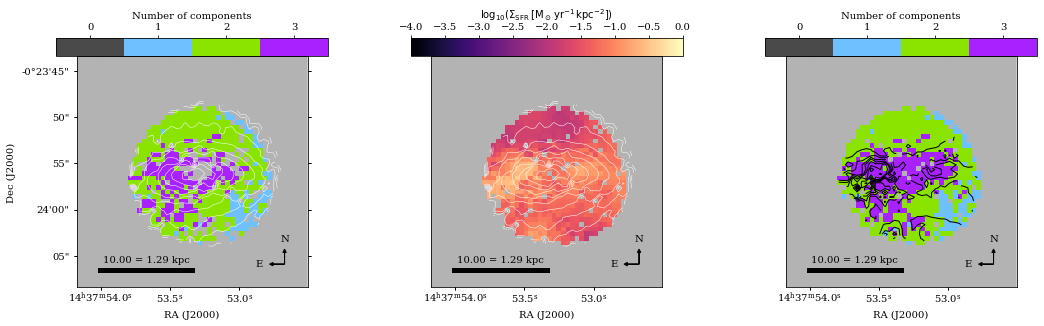

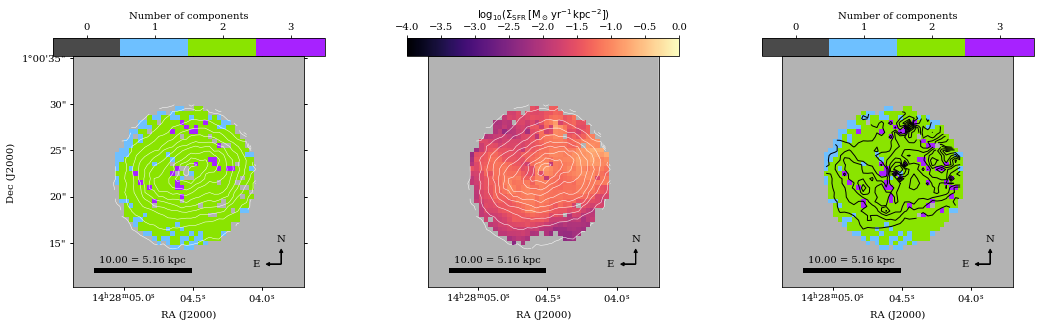

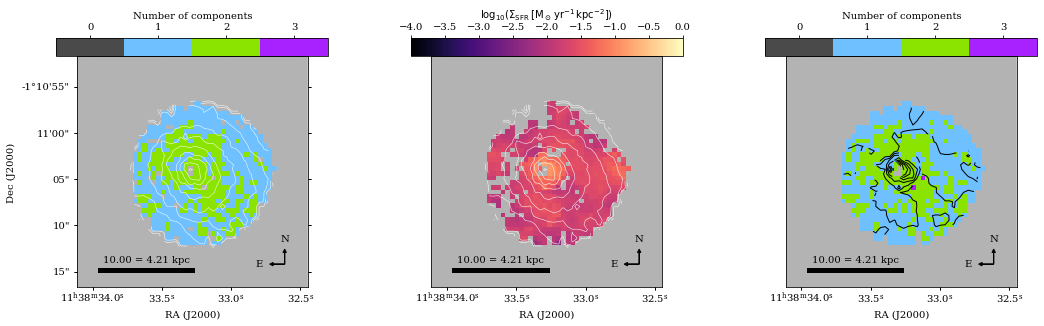

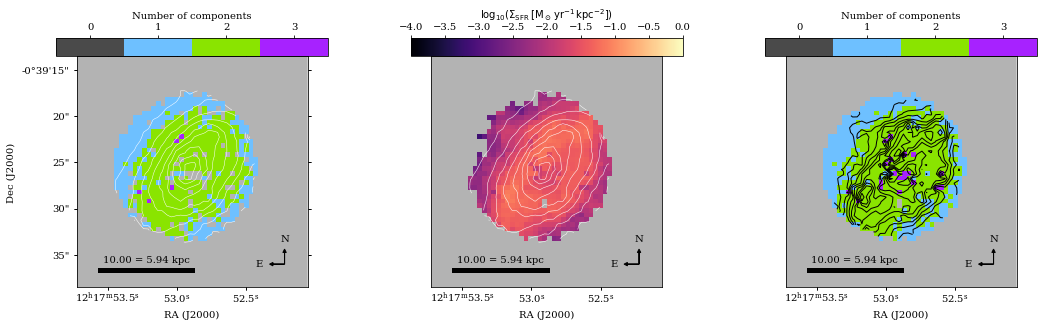

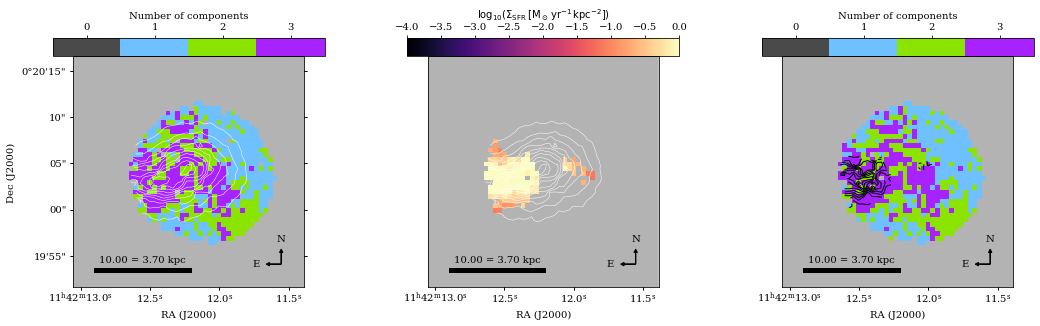

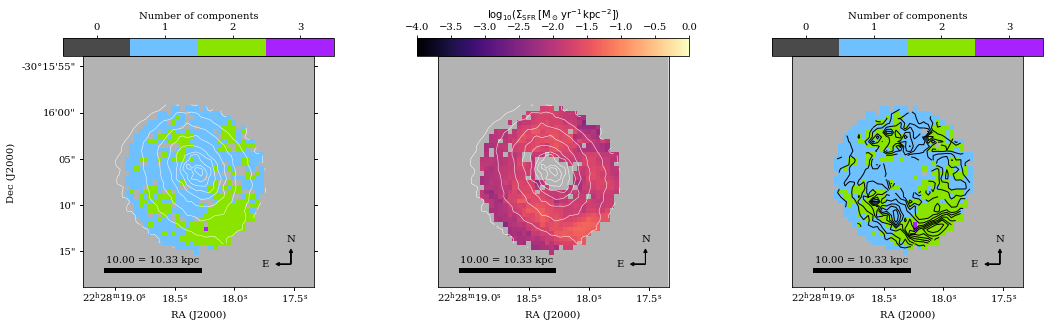

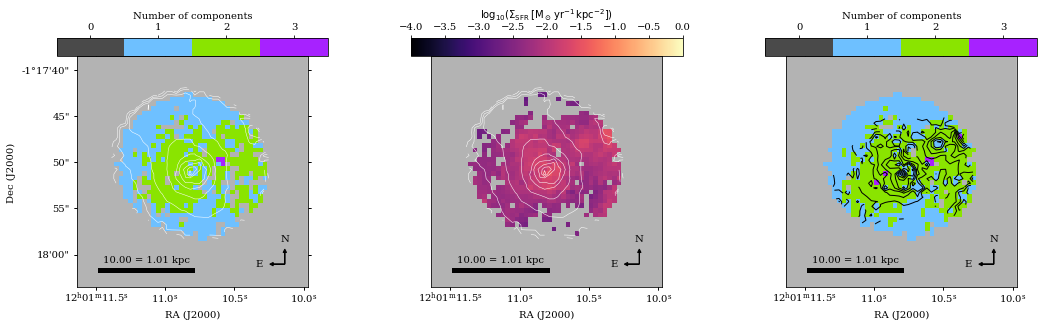

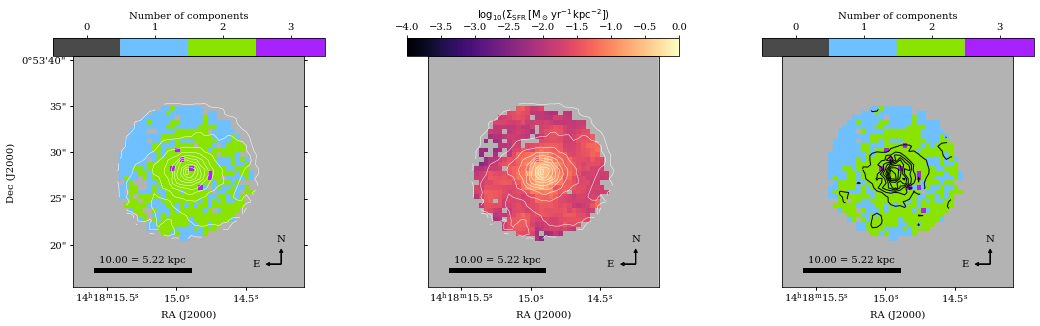

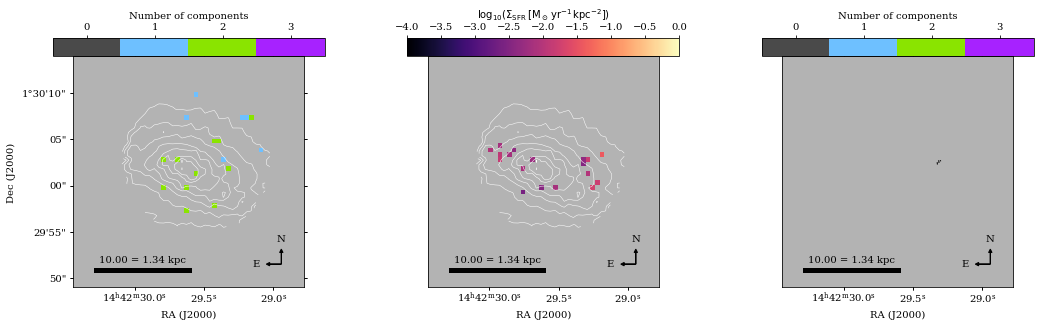

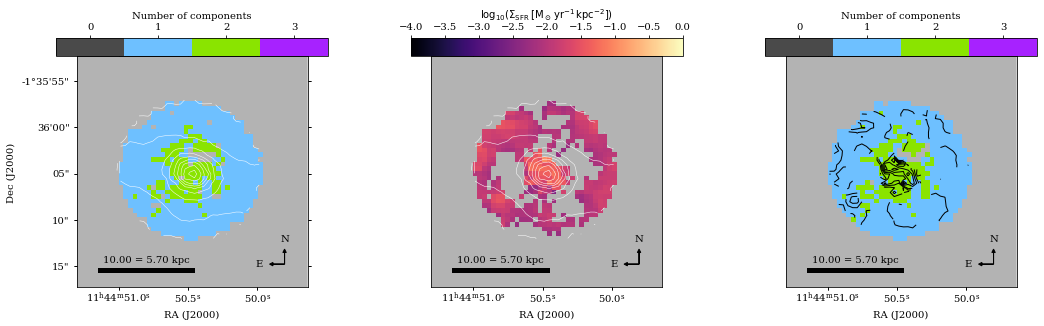

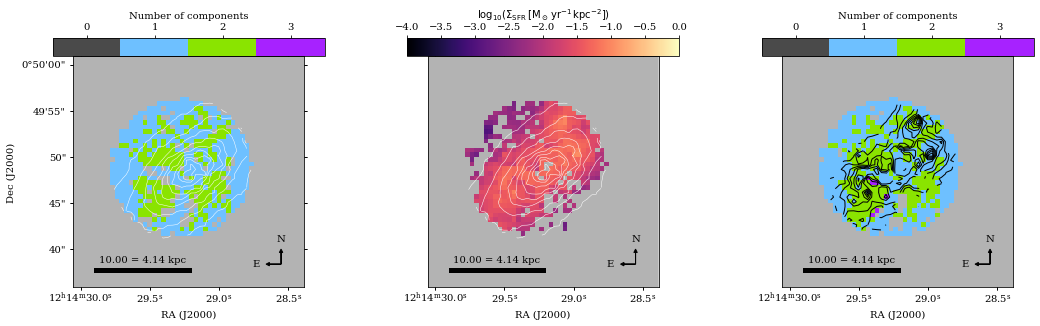

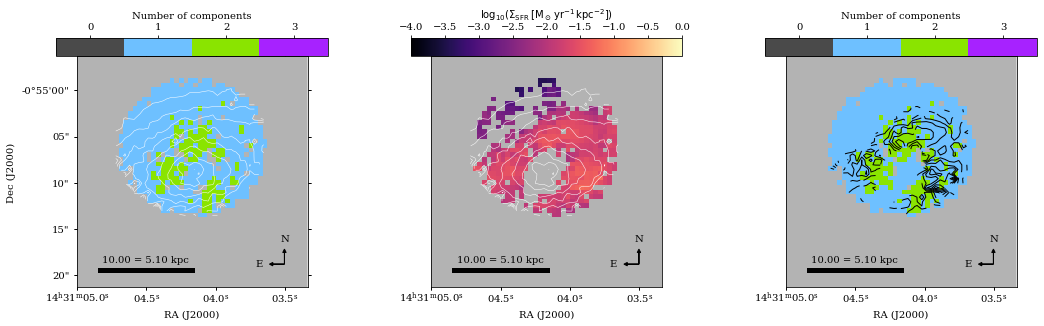

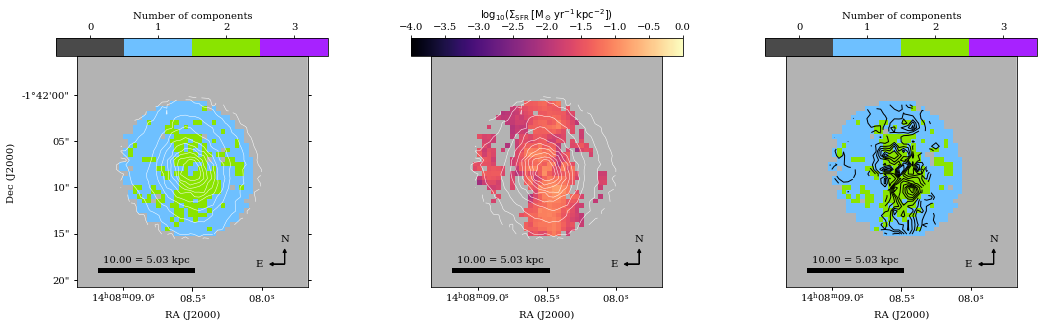

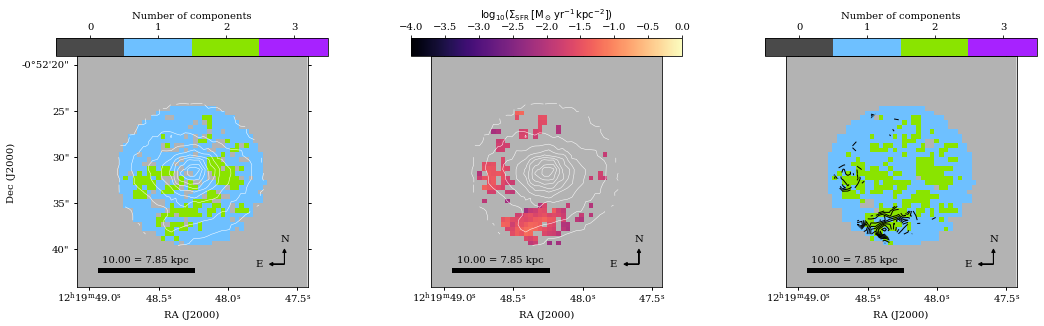

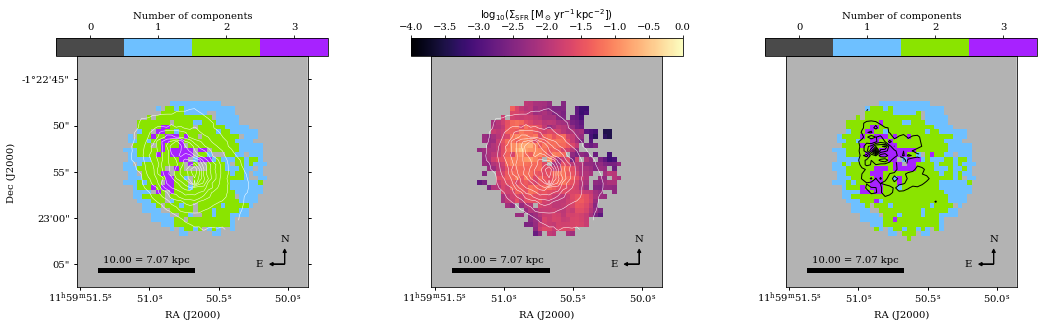

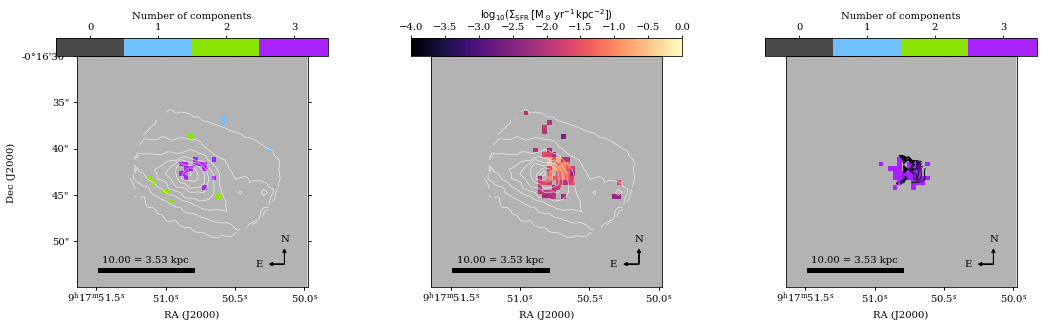

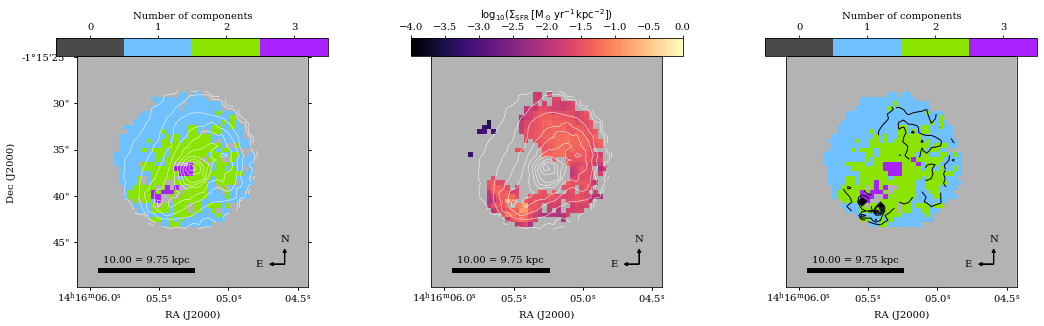

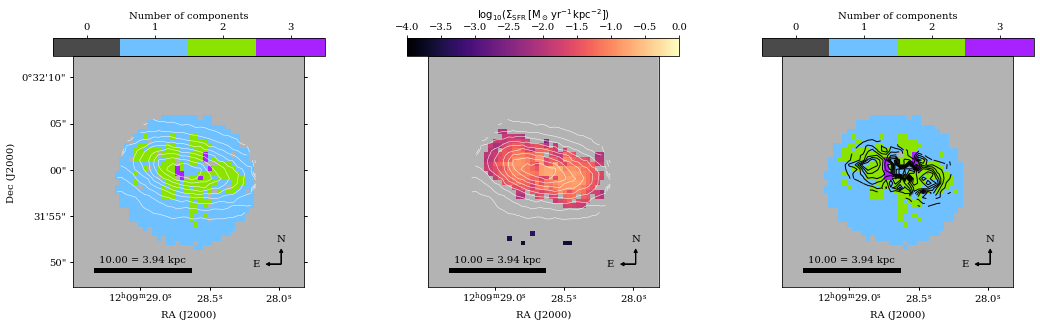

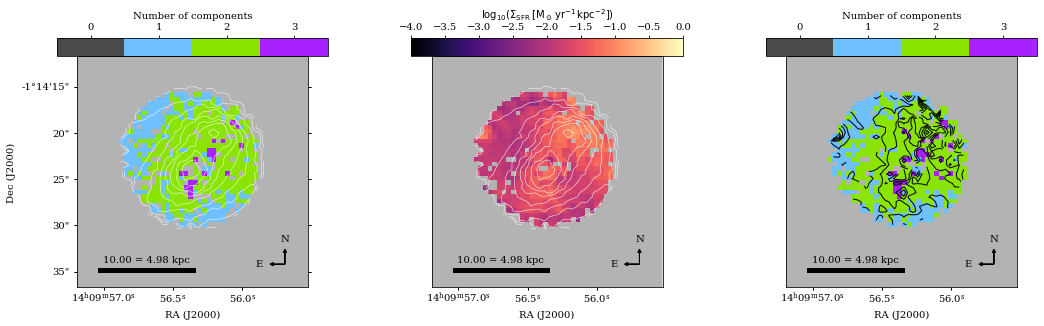

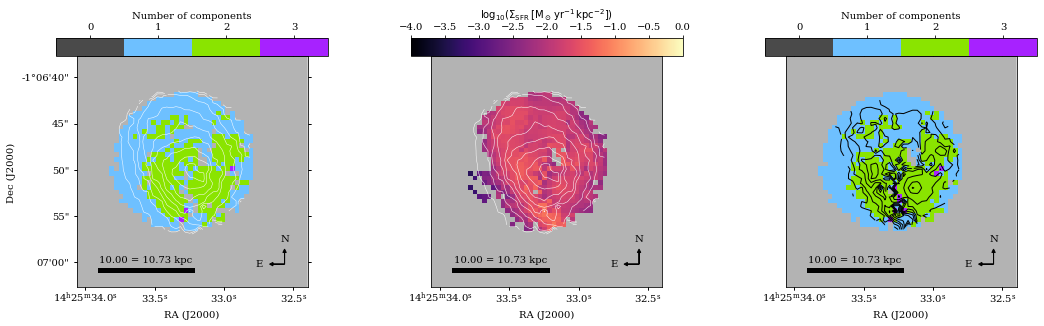

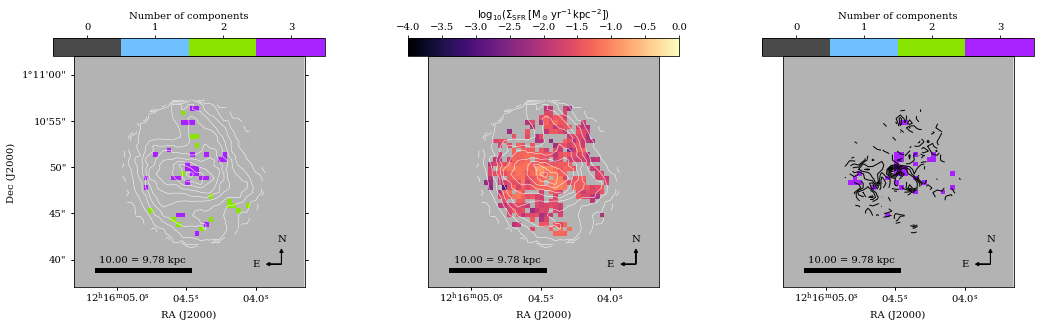

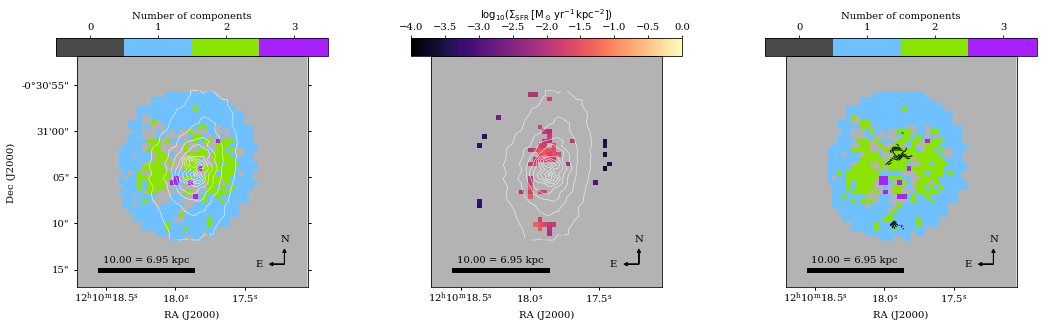

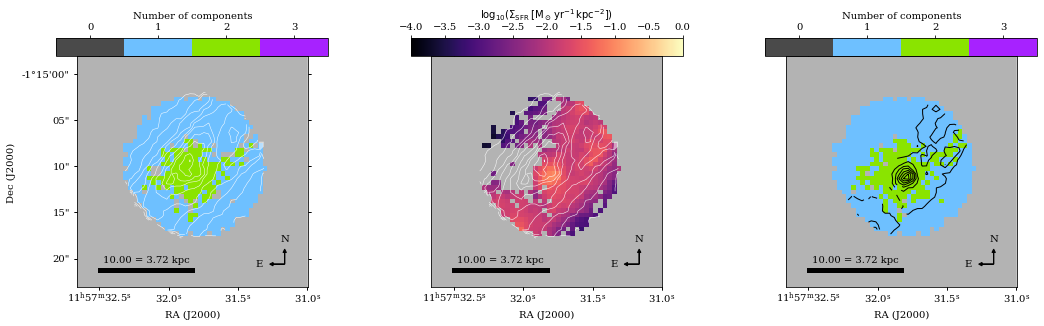

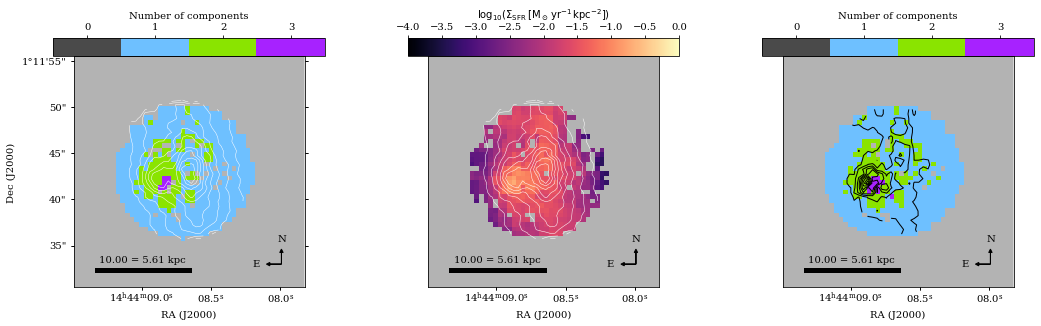

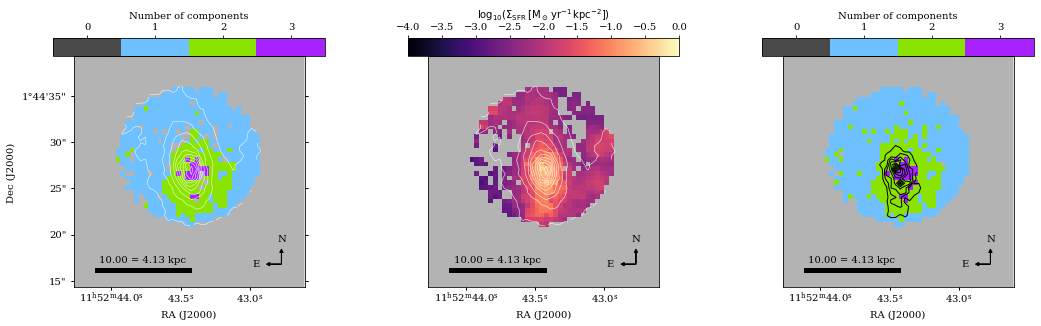

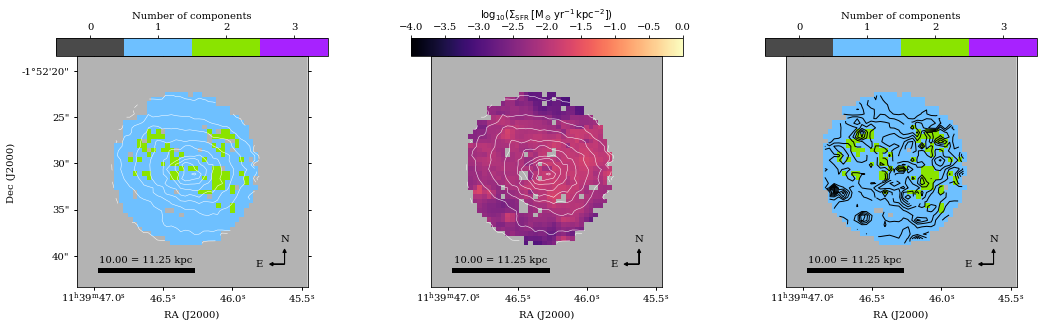

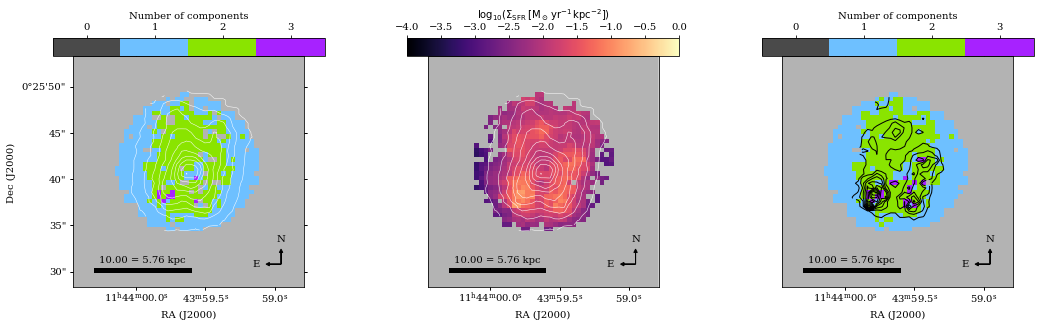

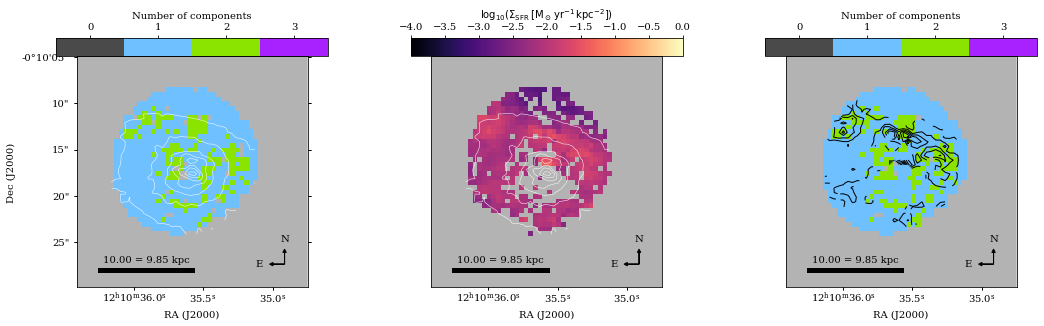

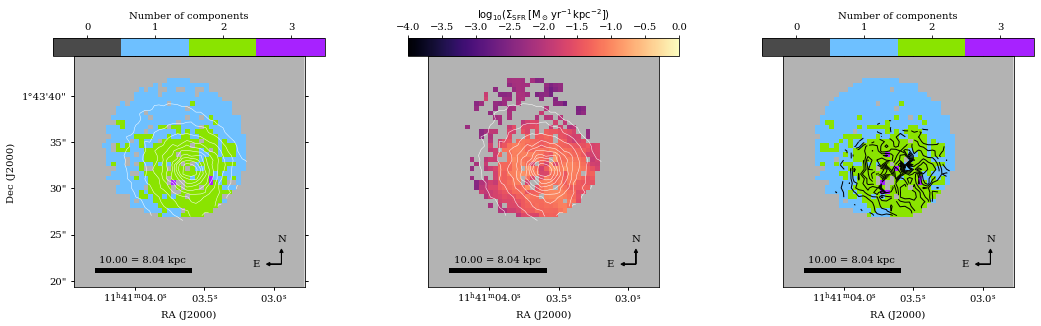

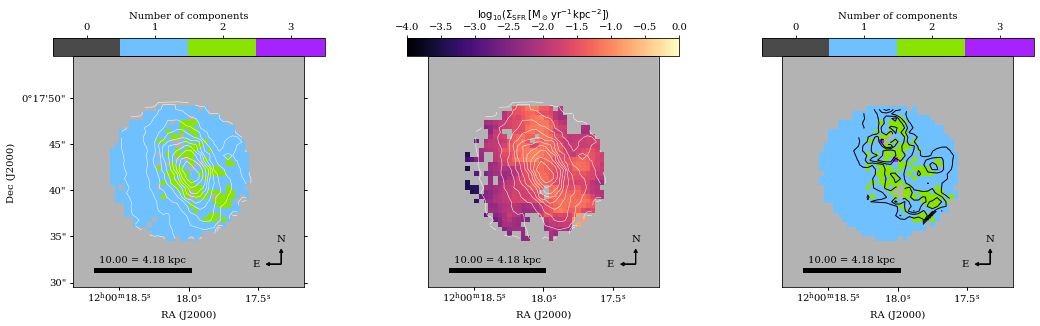

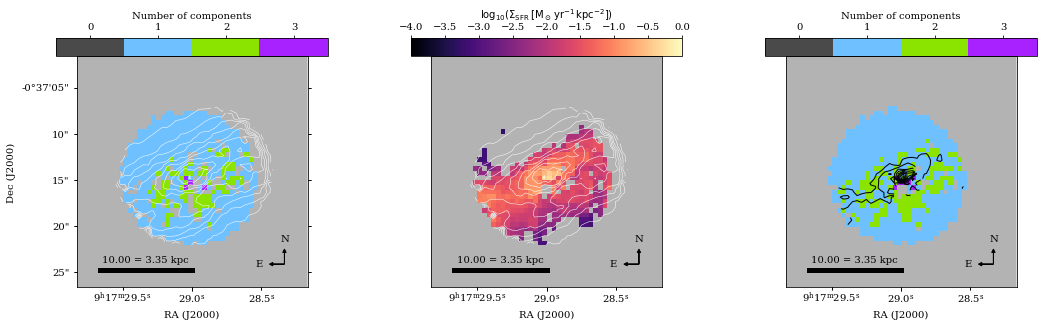

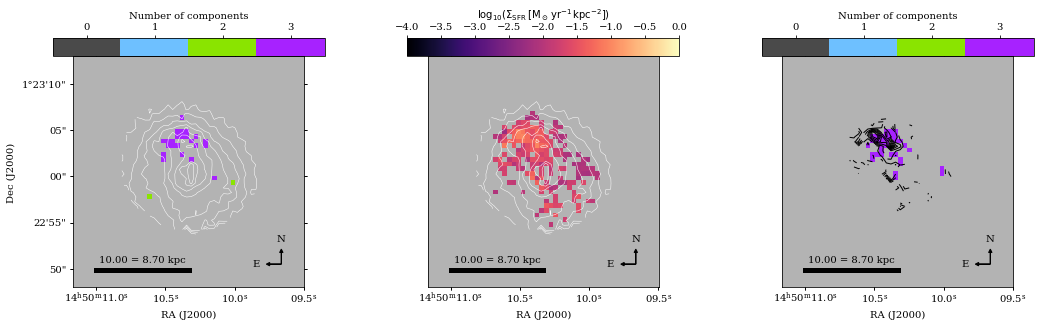

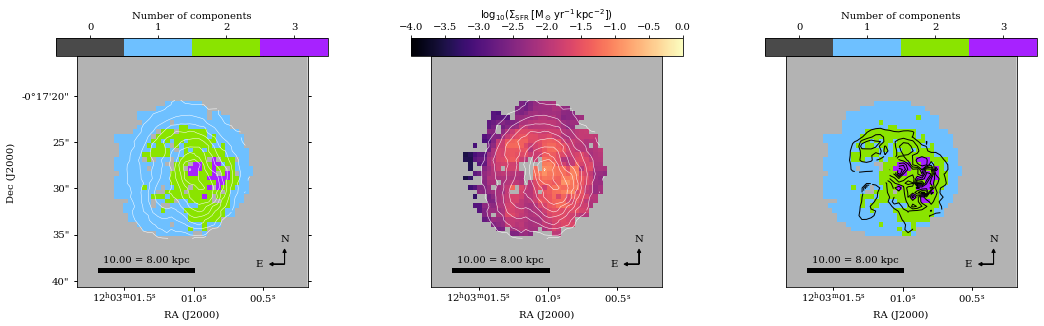

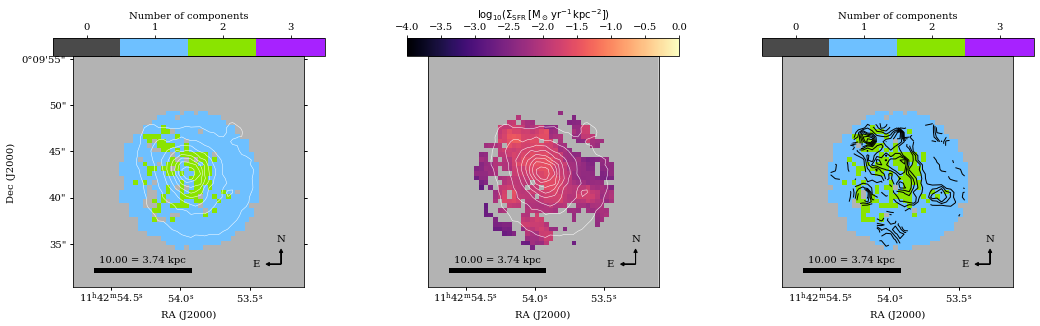

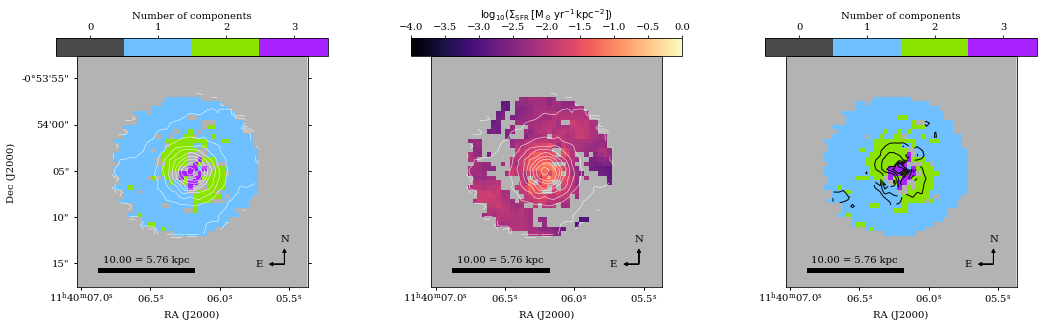

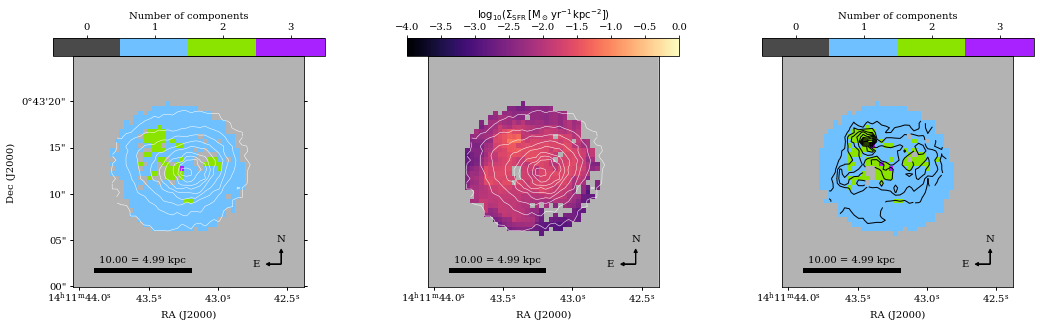

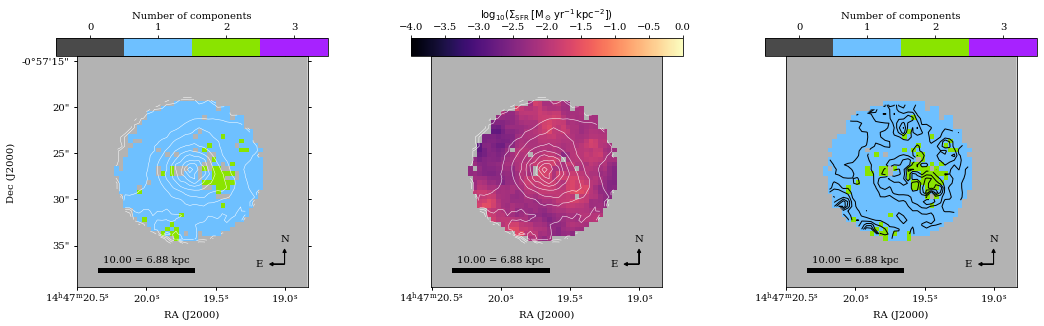

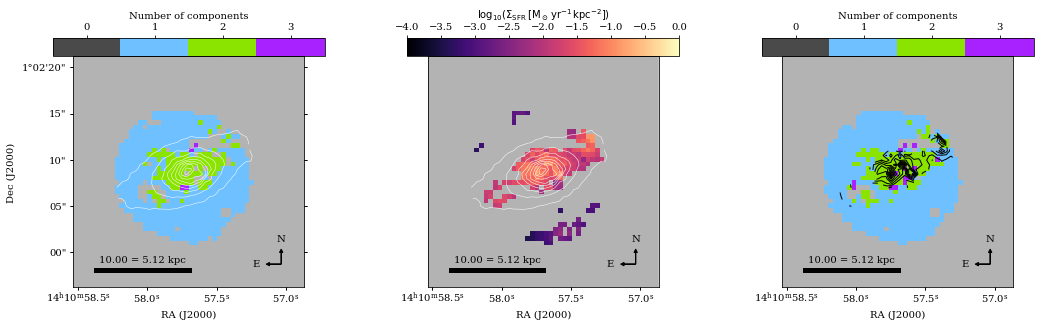

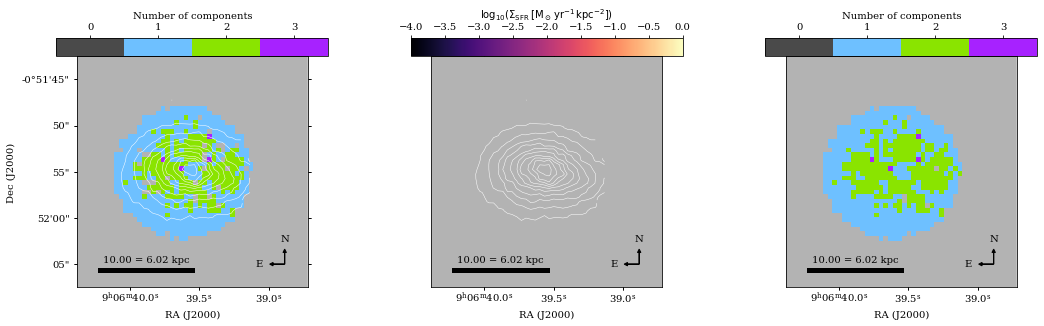

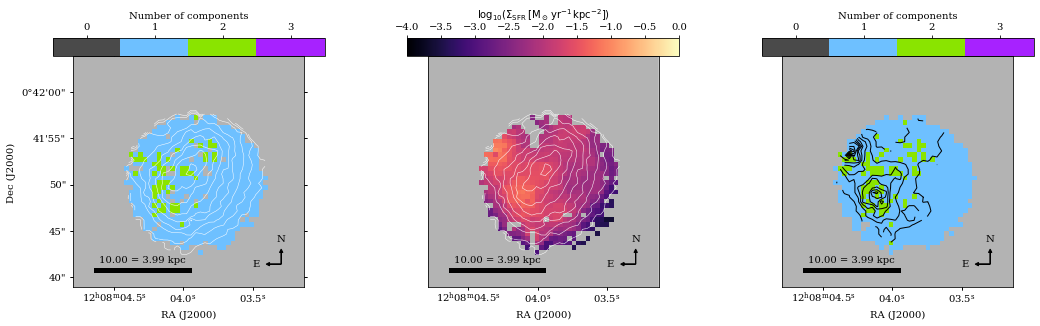

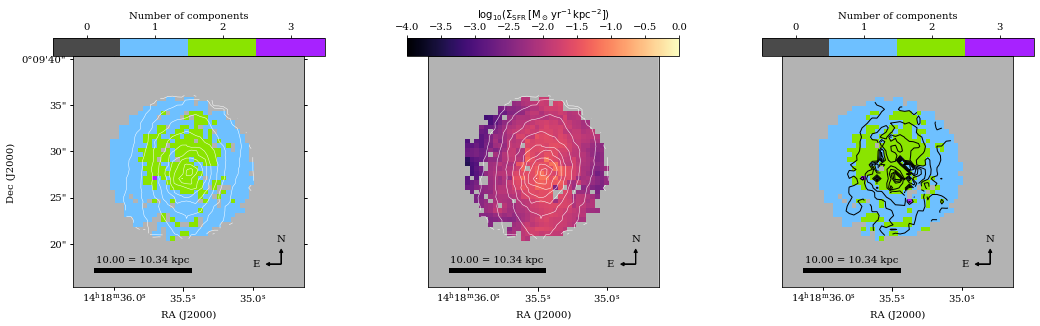

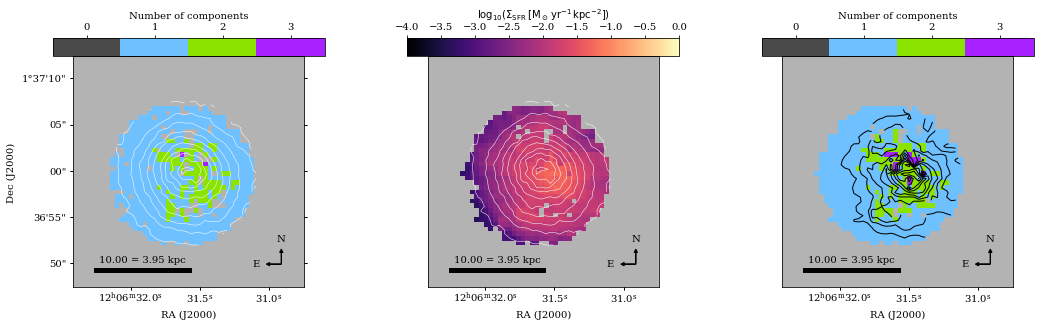

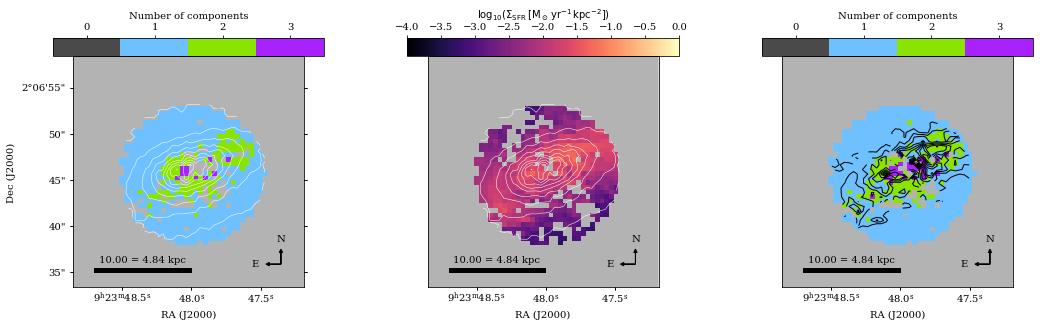

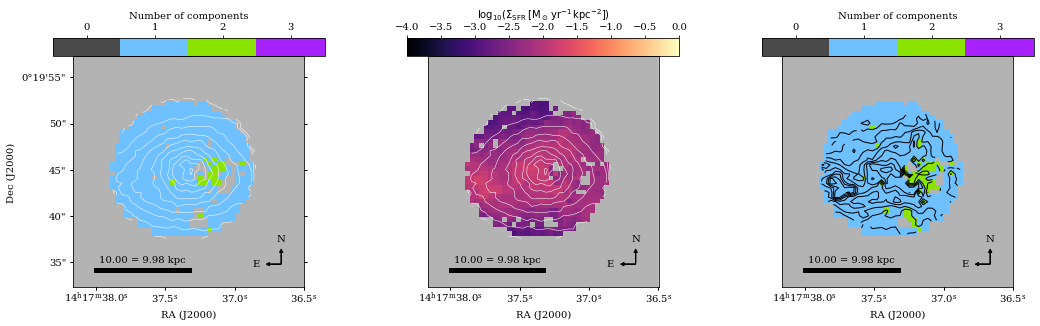

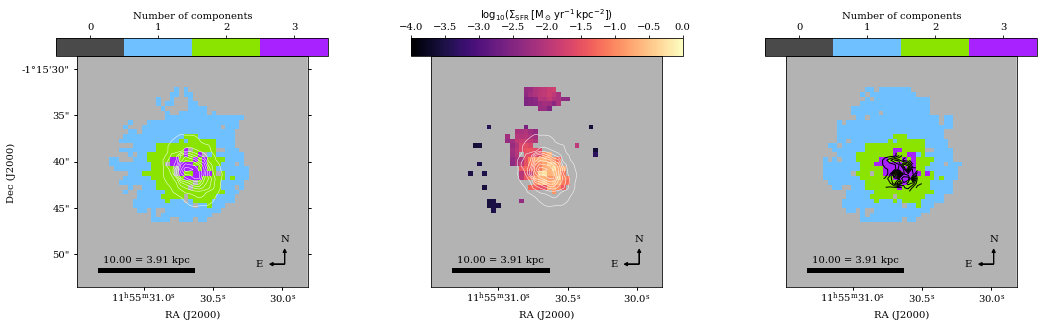

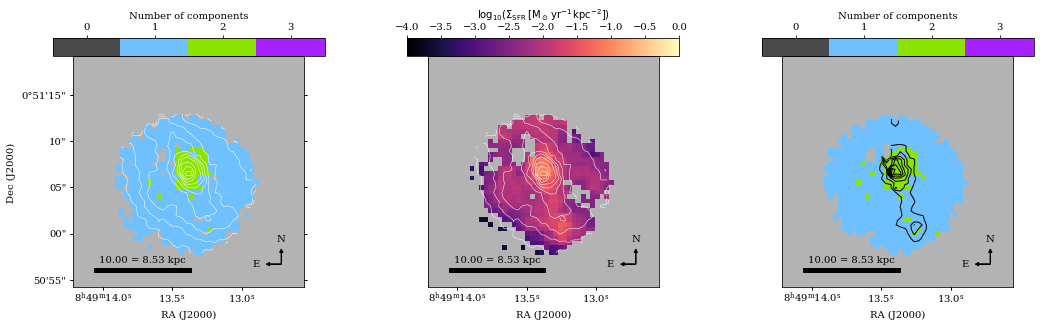

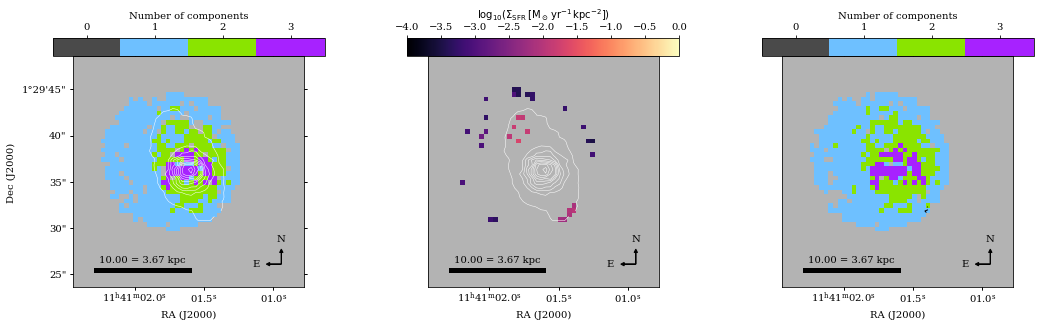

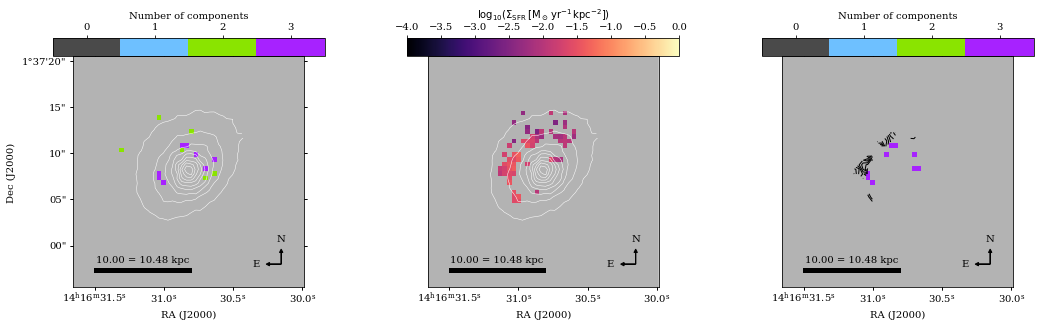

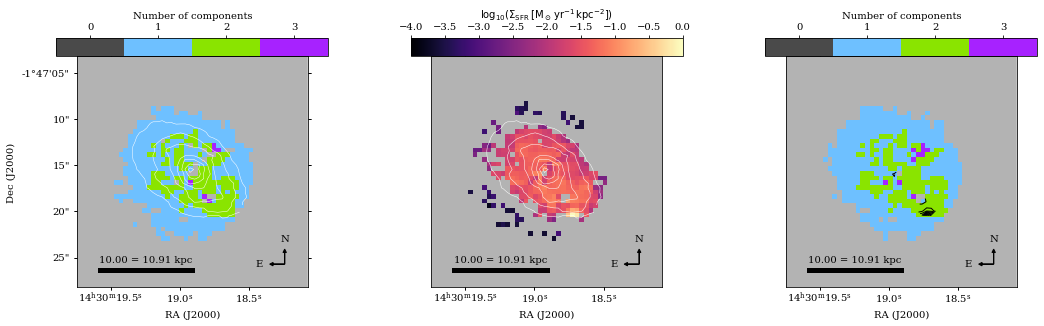

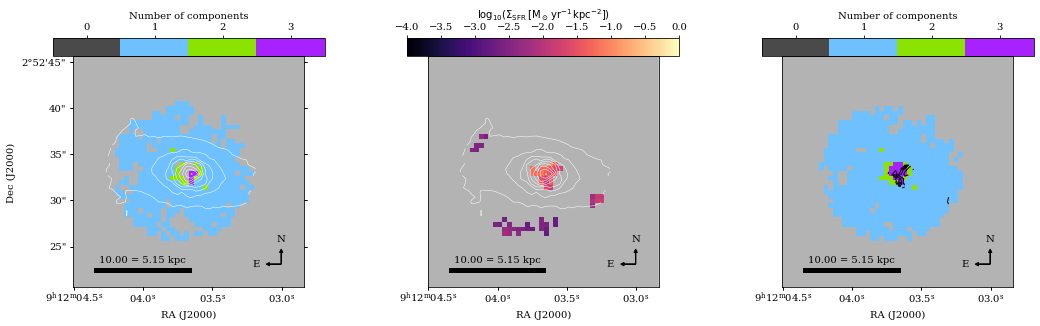

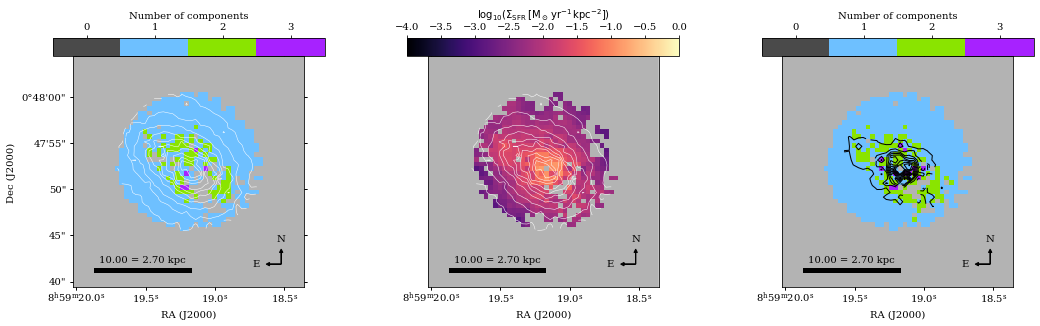

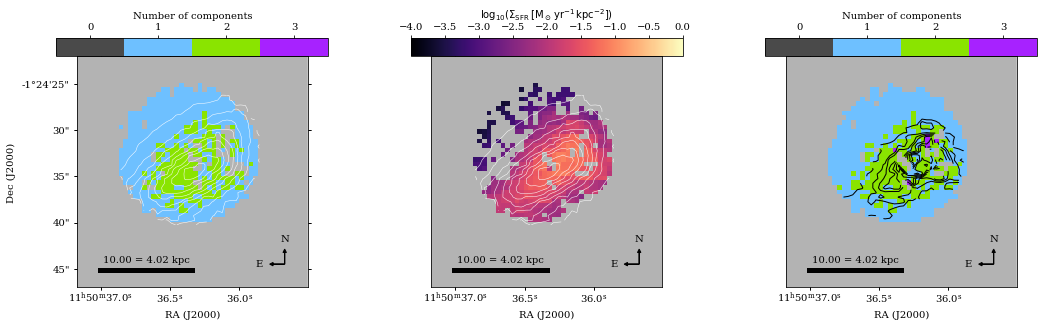

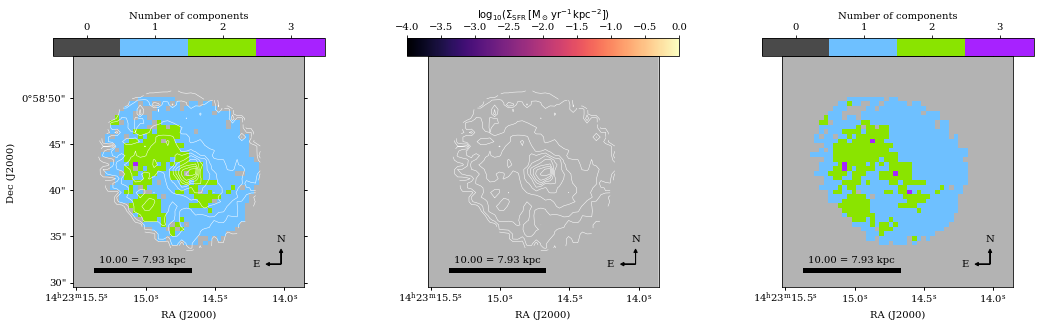

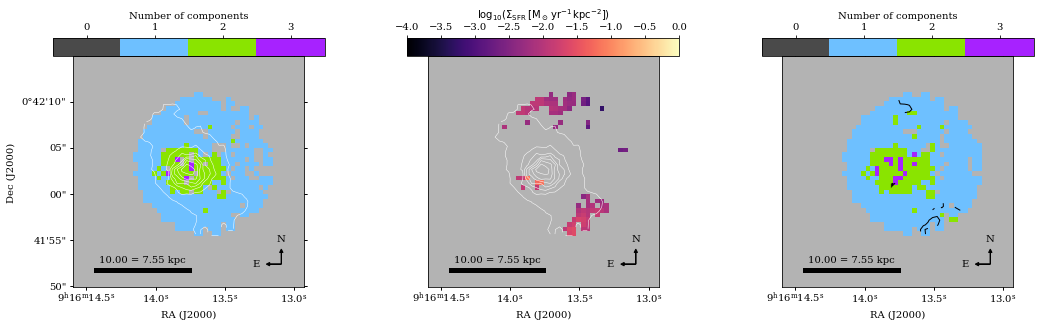

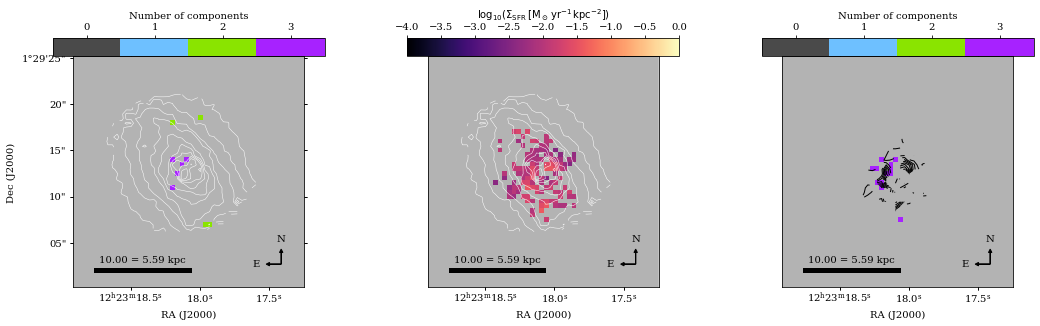

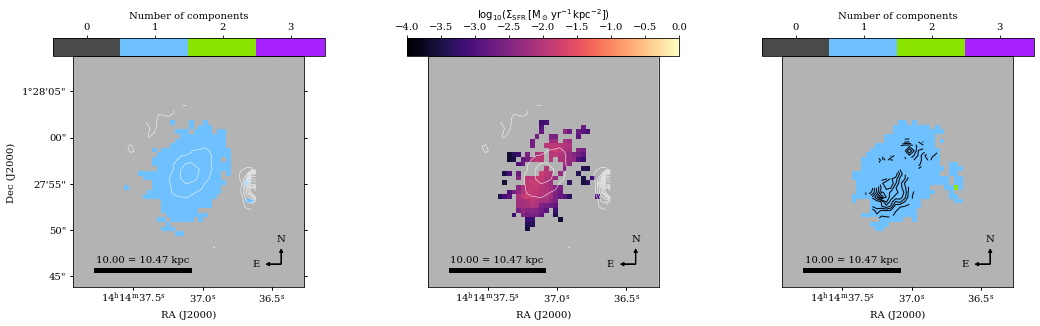

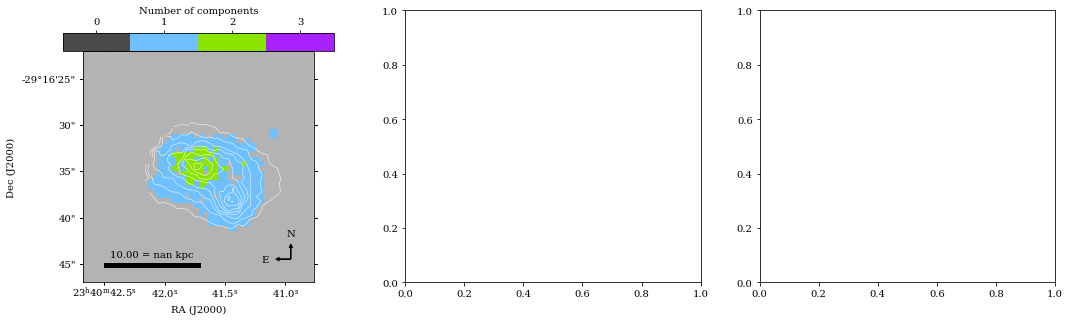

In [14]:
for gal in gals_good:
    # Load LZIFU data
    df_gal = load_lzifu_galaxy(gal=gal, bin_type="default", ncomponents="recom",
                       eline_SNR_min=5,
                       sigma_gas_SNR_cut=True,
                       vgrad_cut=False,
                       stekin_cut=False)
    df_gal.loc[df_gal["Number of components"] == 0, "Number of components"] = np.nan
    
    # Get SAMI data for this galaxy
    df_gal_sami = df_sami[df_sami["catid"] == gal]
    df_gal_sami.loc[df_gal_sami["Number of components"] == 0, "Number of components"] = np.nan

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

    # Number of components
    fig = plot2dmap(df_gal=df_gal, bin_type="default", survey="sami", 
                    col_z="Number of components", show_title=False, ax=axs[0],
                    plot_colorbar=True, cax_orientation="horizontal")

    # SFR surface density
    fig = plot2dmap(df_gal=df_gal_sami, bin_type="default", survey="sami", 
                    col_z="log SFR surface density", ax=axs[1], show_title=False, 
                    plot_colorbar=True, cax_orientation="horizontal")

    # Plot # of components overlaid with contours showing SFR surface density
    # NOTE: we use df_gal_sami here because the number of components is derived from SAMI DR3 anyway,
    # and log SFR surface density isn't defined in LZIFU
    fig = plot2dmap(df_gal=df_gal_sami,
                    bin_type="default", survey="sami", 
                    col_z="Number of components", show_title=False,  ax=axs[2],
                    col_z_contours="SFR surface density", linewidths=1, colors="black",
                    plot_colorbar=True, cax_orientation="horizontal")

    # Turn off axis labels
    axs = fig.get_axes()
    for ax in [axs[2], axs[4]]:
        lat = ax.coords[1]
        lat.set_ticks_visible(False)
        lat.set_ticklabel_visible(False)


### Recreate Fig. 4 of Arribas+2014: is there a correlation between line ratios and line width?

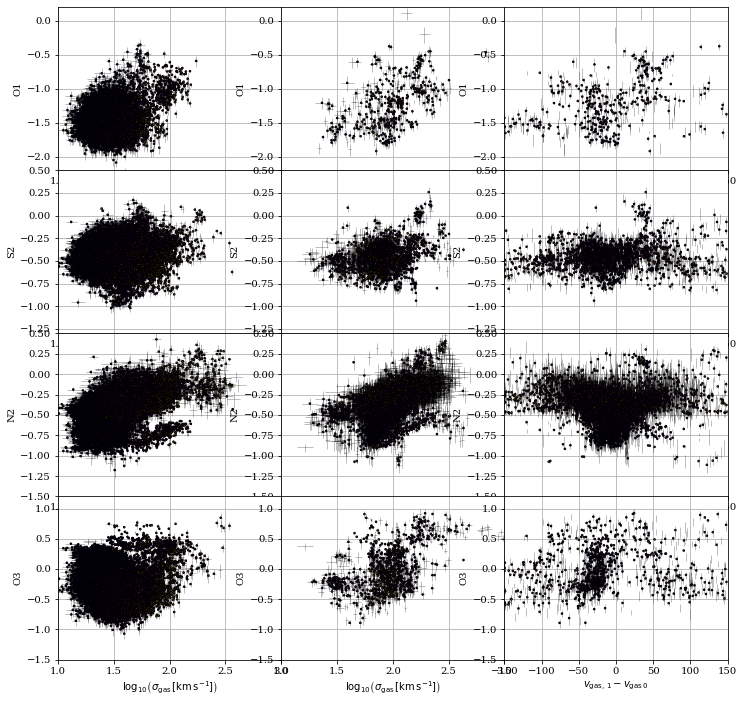

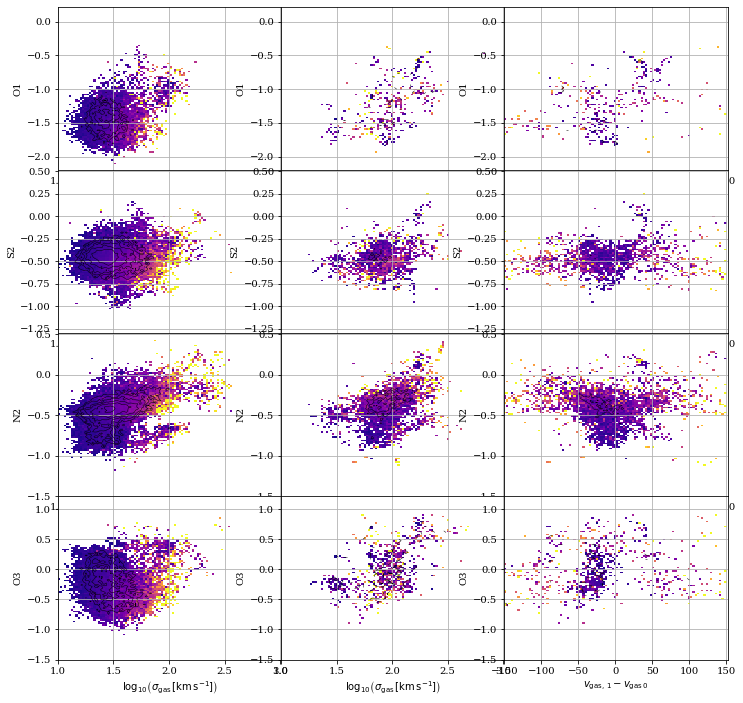

In [15]:
# Scatter plot showing line ratios 
col_y_list = ["log O1", "log S2", "log N2", "log O3"]
col_x_list = ["log sigma_gas (component 0)", "log sigma_gas (component 1)", "delta v_gas (1/0)"]
nrows = len(col_y_list)
ncols = len(col_x_list)

#############################################################################################################
# Represent as scatter plot
#############################################################################################################
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 3 * nrows))
fig.subplots_adjust(wspace=0, hspace=0)

for rr, col_y in enumerate(col_y_list):
    for cc, col_x in enumerate(col_x_list):
        cx = col_x
        cy = col_y if col_y in df.columns else f"{col_y} (component {0 if cc == 0 else 1})"
        plot2dscatter(df=df, col_x=cx, col_y=cy, col_z=f"v_grad (component {0 if cc == 0 else 1})",
                      ax=axs[rr][cc], plot_colorbar=False,
                      markersize=2.5)
        axs[rr][cc].grid()

#############################################################################################################
# Represent as 2D histogram
#############################################################################################################
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 3 * nrows))
fig.subplots_adjust(wspace=0, hspace=0)

for rr, col_y in enumerate(col_y_list):
    for cc, col_x in enumerate(col_x_list):
        cx = col_x
        cy = col_y if col_y in df.columns else f"{col_y} (component {0 if cc == 0 else 1})"
        plot2dhistcontours(df=df, col_x=cx, col_y=cy, col_z=f"v_grad (component {0 if cc == 0 else 1})", log_z=False,
                           ax=axs[rr][cc], plot_colorbar=False)
        axs[rr][cc].grid()
